In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
from ipywidgets import ToggleButton, interactive
from matplotlib.backend_bases import MouseEvent
import matplotlib.lines as mlines
from matplotlib.table import Table
import seaborn as sns
from scipy.stats import ttest_rel

In [2]:
# Load the Metrics Excel file for macOS
metrics_file_path = (r"/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /BiomechanicsExercise_Metrics_Limited.xlsm")
signals_file_path = (r"/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /BiomechanicsExercise_Signals_New_Limited.xlsm")

metrics_df = pd.read_excel(metrics_file_path, sheet_name=None)

# Read the sheets
metrics_df = pd.read_excel(metrics_file_path, sheet_name='BiomechanicsExercise_Metrics_Li')
signals_df = pd.read_excel(signals_file_path, sheet_name='BiomechanicsExercise_Signals_Ne')

# Display the sheet names to understand the structure
metrics_df.keys()
signals_df.keys()

def x_dot(time, position):
    slope = np.gradient(position, time)
    return slope

# Extract the correct sheet from Signals into a DataFrame
signals_data = signals_df
# Load the specific sheet into a DataFrame correctly
metrics_data = metrics_df

# Select relevant columns correctly from Metrics
metrics_relevant_corrected = metrics_data[['INNING', 'PITCHER_PITCH_COUNT', 'PITCH_TYPE', 'RELEASE_SPEED', 'SPIN_RATE']]

# Merge Signals and Metrics DataFrames
merged_data_corrected = pd.merge(signals_data, metrics_relevant_corrected, how='left', on=['INNING', 'PITCH_TYPE', 'PITCHER_PITCH_COUNT'])

In [3]:
# Calculate the angular velocities using numerical differentiation (derivative with respect to time)

# Step 1: Define a function to compute angular velocities using finite differences
def compute_velocity(df, column, time_col='ZERO_TIME'):
    """Calculate the angular velocity as the derivative of angular position."""
    return df[column].diff() / df[time_col].diff()

# Derivative Calculation
def compute_derivative(time, signal):
    """Compute the derivative of a signal with respect to time."""
    return np.gradient(signal, time)

# Custom Noise Filter
def apply_custom_filter(signal, window_length=11, polyorder=2):
    """Apply a Savitzky-Golay filter to smooth the signal."""
    return savgol_filter(signal, window_length=window_length, polyorder=polyorder)


# Calculate angular velocities for shoulder, elbow, pelvis, and trunk
signals_data['Shoulder_Internal_Rotation_Velocity'] = compute_velocity(signals_data, 'SHOULDER_Z')
signals_data['Elbow_Extension_Velocity'] = compute_velocity(signals_data, 'ELBOW_X')
signals_data['Pelvis_Rotational_Velocity'] = compute_velocity(signals_data, 'PELVIS_Z')
signals_data['Trunk_Rotational_Velocity'] = compute_velocity(signals_data, 'TRUNK_Z')

# Drop the NaN values that result from differentiation
signals_data.dropna(subset=[
    'Shoulder_Internal_Rotation_Velocity', 'Elbow_Extension_Velocity', 
    'Pelvis_Rotational_Velocity', 'Trunk_Rotational_Velocity'
], inplace=True)

# Display the calculated velocities
signals_data.head()


,INNING,PITCHER_PITCH_COUNT,PITCHER_NAME_LAST_FIRST,PITCH_TYPE,FRAME,ZERO_TIME,BACKHIP_Z,BACKKNEE_X,MODEL_COG_LAB_X,MODEL_COG_LAB_Y,...,SHOULDER_X,SHOULDER_Y,SHOULDER_Z,TRUNK_X,TRUNK_Y,TRUNK_Z,Shoulder_Internal_Rotation_Velocity,Elbow_Extension_Velocity,Pelvis_Rotational_Velocity,Trunk_Rotational_Velocity
1,1,12,Player A,Curveball,2,0.003822,1.456505,-38.298092,-0.200673,0.221094,...,-12.343470,-11.237032,46.786945,-7.841507,-1.390891,-16.818941,17.522240,94.183673,-85.879121,-9.913396
2,1,12,Player A,Curveball,3,0.007644,1.640335,-38.529594,-0.200751,0.221835,...,-12.114245,-11.346584,46.331169,-7.989136,-1.292528,-16.895252,-119.250654,89.486656,-93.138409,-19.966248
3,1,12,Player A,Curveball,4,0.011467,1.853975,-38.772511,-0.200812,0.222485,...,-11.060385,-11.442121,45.181335,-8.155247,-1.213876,-17.013985,-300.767460,70.939576,-100.044729,-31.057546
4,1,12,Player A,Curveball,5,0.015289,2.100848,-39.026485,-0.200854,0.223061,...,-9.088291,-11.504252,43.223801,-8.338200,-1.157729,-17.177469,-512.175301,43.622449,-106.513344,-42.774464
5,1,12,Player A,Curveball,6,0.019111,2.381385,-39.290218,-0.200884,0.223580,...,-6.332642,-11.513216,40.521503,-8.534177,-1.123652,-17.384865,-707.037677,9.837258,-111.913396,-54.263736


In [198]:
# Step 1: Recompute the mean and standard deviation for pitch velocity and spin rate
velocity_spinrate_stats = metrics_data.groupby(['INNING', 'PITCH_TYPE']).agg({
    'RELEASE_SPEED': ['mean', 'std'],
    'SPIN_RATE': ['mean', 'std']
})

# Flatten the column names and rename for clarity
velocity_spinrate_stats.columns = ['Mean_Pitch_Velocity', 'Std_Pitch_Velocity', 'Mean_Spin_Rate', 'Std_Spin_Rate']
velocity_spinrate_stats.reset_index(inplace=True)

# Step 2: Extract peak values for angular velocities, Max External Rotation, and Max Elbow Valgus Torque
pitch_peak_data = signals_data.groupby(['INNING', 'PITCH_TYPE', 'PITCHER_PITCH_COUNT']).apply(
    lambda group: pd.Series({
        'Peak_Shoulder_Internal_Rotation_Velocity': group['Shoulder_Internal_Rotation_Velocity'].abs().max(),
        'Peak_Elbow_Extension_Velocity': group['Elbow_Extension_Velocity'].abs().max(),
        'Peak_Pelvis_Rotational_Velocity': group['Pelvis_Rotational_Velocity'].abs().max(),
        'Peak_Trunk_Rotational_Velocity': group['Trunk_Rotational_Velocity'].abs().max(),
        'Max_External_Rotation': group['SHOULDER_Z'].abs().max(),  # Assuming 'SHOULDER_X' captures external rotation
        'Max_Elbow_Varus_Torque': group['ELBOWMOMENT_Y'].abs().max()  # Assuming 'ELBOWMOMENT_Y' captures valgus torque
    })
).reset_index()

# Step 3: Filter peaks within valid ranges for all metrics (customize the range for each metric as necessary)
filtered_peak_data = pitch_peak_data[
    (pitch_peak_data['Peak_Shoulder_Internal_Rotation_Velocity'].between(400, 5900)) &
    (pitch_peak_data['Peak_Elbow_Extension_Velocity'].between(400, 5900)) &
    (pitch_peak_data['Peak_Pelvis_Rotational_Velocity'].between(400, 5900)) &
    (pitch_peak_data['Peak_Trunk_Rotational_Velocity'].between(400, 5900)) &
    (pitch_peak_data['Max_External_Rotation'].between(-200, 200)) &  # Customize range for external rotation if necessary
    (pitch_peak_data['Max_Elbow_Varus_Torque'].between(0, 200))  # Customize range for valgus torque based on expected values
]

# Step 4: Calculate mean and standard deviation for the filtered peaks
filtered_peak_stats = filtered_peak_data.groupby(['INNING', 'PITCH_TYPE']).agg({
    'Peak_Shoulder_Internal_Rotation_Velocity': ['mean', 'std'],
    'Peak_Elbow_Extension_Velocity': ['mean', 'std'],
    'Peak_Pelvis_Rotational_Velocity': ['mean', 'std'],
    'Peak_Trunk_Rotational_Velocity': ['mean', 'std'],
    'Max_External_Rotation': ['mean', 'std'],
    'Max_Elbow_Varus_Torque': ['mean', 'std']
})

# Flatten the column names for clarity
filtered_peak_stats.columns = [
    'Peak_Shoulder_Internal_Rotation_Velocity_Mean', 'Peak_Shoulder_Internal_Rotation_Velocity_Std',
    'Peak_Elbow_Extension_Velocity_Mean', 'Peak_Elbow_Extension_Velocity_Std',
    'Peak_Pelvis_Rotational_Velocity_Mean', 'Peak_Pelvis_Rotational_Velocity_Std',
    'Peak_Trunk_Rotational_Velocity_Mean', 'Peak_Trunk_Rotational_Velocity_Std',
    'Max_External_Rotation_Mean', 'Max_External_Rotation_Std',
    'Max_Elbow_Varus_Torque_Mean', 'Max_Elbow_Varus_Torque_Std'
]
filtered_peak_stats.reset_index(inplace=True)

# Step 5: Merge with the velocity and spin rate stats
final_filtered_stats = pd.merge(velocity_spinrate_stats, filtered_peak_stats, on=['INNING', 'PITCH_TYPE'], how='left')

# Corrected replacement logic for single pitch scenarios, using explicit column names
for col, std_col in [('Mean_Pitch_Velocity', 'Std_Pitch_Velocity'), ('Mean_Spin_Rate', 'Std_Spin_Rate')]:
    final_filtered_stats[col] = final_filtered_stats.apply(
        lambda row: row[col] if not pd.isna(row[std_col]) else metrics_data[
            (metrics_data['INNING'] == row['INNING']) & 
            (metrics_data['PITCH_TYPE'] == row['PITCH_TYPE'])
        ]['RELEASE_SPEED' if col == 'Mean_Pitch_Velocity' else 'SPIN_RATE'].values[0], axis=1
    )

# Replace remaining NaN standard deviation values with zero for single-pitch cases
std_columns = [col for col in final_filtered_stats.columns if 'Std' in col]
for col in std_columns:
    final_filtered_stats[col] = final_filtered_stats[col].fillna(0)

# Output the corrected table with Max External Rotation and Max Elbow Valgus Torque included
display(final_filtered_stats)

# Save the DataFrame to an Excel file again
output_file_path = "/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 1/question_1_full_metrics.xlsx"
final_filtered_stats.to_excel(output_file_path, index=False)

# Return the file path for download
output_file_path


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/4265342440.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pitch_peak_data = signals_data.groupby(['INNING', 'PITCH_TYPE', 'PITCHER_PITCH_COUNT']).apply(


,INNING,PITCH_TYPE,Mean_Pitch_Velocity,Std_Pitch_Velocity,Mean_Spin_Rate,Std_Spin_Rate,Peak_Shoulder_Internal_Rotation_Velocity_Mean,Peak_Shoulder_Internal_Rotation_Velocity_Std,Peak_Elbow_Extension_Velocity_Mean,Peak_Elbow_Extension_Velocity_Std,Peak_Pelvis_Rotational_Velocity_Mean,Peak_Pelvis_Rotational_Velocity_Std,Peak_Trunk_Rotational_Velocity_Mean,Peak_Trunk_Rotational_Velocity_Std,Max_External_Rotation_Mean,Max_External_Rotation_Std,Max_Elbow_Varus_Torque_Mean,Max_Elbow_Varus_Torque_Std
0,1,Curveball,82.260517,0.559430,2955.646667,88.802402,4917.430614,429.105130,2473.276233,182.301120,770.074664,24.771722,1118.791999,12.124903,177.014565,3.798451,118.881641,10.064284
1,1,Fastball,95.544671,0.857512,2233.980000,68.551684,4740.543546,226.958867,2359.370394,104.274940,782.231093,15.728386,1144.126761,17.762639,178.669076,1.820366,126.213696,9.155190
2,7,Changeup,86.450300,0.000000,1999.980000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
3,7,Curveball,80.970660,0.587149,2999.780000,62.291251,4792.029595,351.501009,2411.742322,103.400415,800.654548,14.424826,1111.415862,16.109526,173.985388,2.593932,113.942987,15.798928
4,7,Fastball,93.642100,0.497514,2278.180000,40.493209,4298.602221,45.766931,2489.529734,83.832786,797.159420,19.227520,1120.390305,21.751383,171.118176,2.388807,135.180584,3.276458
5,7,Sinker,93.298000,0.518528,2112.646667,87.191360,4654.829463,0.000000,2520.614175,0.000000,819.878297,0.000000,1143.349625,0.000000,178.957840,0.000000,133.922104,0.000000


'/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 1/question_1_full_metrics.xlsx'

In [323]:
import pandas as pd

# Sample data similar to what you have shared
data = {
    'INNING': [1, 1, 7, 7, 7, 7],
    'PITCH_TYPE': ['Curveball', 'Fastball', 'Changeup', 'Curveball', 'Fastball', 'Sinker'],
    'Mean_Pitch_Velocity': [82.3, 95.5, 86.5, 81.0, 93.6, 93.3],
    'Std_Pitch_Velocity': [0.6, 0.9, 0.0, 0.6, 0.5, 0.5],
    'Mean_Spin_Rate': [2955.6, 2234.0, 2000.0, 2999.8, 2278.2, 2112.6],
    'Std_Spin_Rate': [88.80, 68.55, 0.00, 62.29, 40.49, 87.19],
    'Peak_Shoulder_Internal_Rotation_Velocity_Mean': [4917.43, 4740.54, None, 4792.03, 4298.60, 4654.83],
    'Peak_Shoulder_Internal_Rotation_Velocity_Std': [429.11, 226.96, None, 351.50, 45.77, 0.00],
    'Peak_Elbow_Extension_Velocity_Mean': [2473.28, 2359.37, None, 2411.74, 2489.53, 2520.61],
    'Peak_Elbow_Extension_Velocity_Std': [182.30, 104.27, None, 103.40, 83.83, 0.00],
    'Peak_Pelvis_Rotational_Velocity_Mean': [770.07, 782.23, None, 800.65, 797.16, 819.88],
    'Peak_Pelvis_Rotational_Velocity_Std': [24.77, 15.73, None, 14.42, 19.23, 0.00],
    'Peak_Trunk_Rotational_Velocity_Mean': [1118.79, 1144.13, None, 1111.42, 1120.39, 1143.35],
    'Peak_Trunk_Rotational_Velocity_Std': [12.12, 17.76, None, 16.11, 21.75, 0.00],
    'Max_External_Rotation_Mean': [177.01, 178.67, None, 173.99, 171.12, 178.96],
    'Max_External_Rotation_Std': [3.80, 1.82, None, 2.59, 2.39, 0.00],
    'Max_Elbow_Varus_Torque_Mean': [118.88, 126.21, None, 113.94, 135.18, 133.92],
    'Max_Elbow_Varus_Torque_Std': [10.06, 9.16, None, 15.80, 3.28, 0.00]
}

# Create the initial DataFrame
df = pd.DataFrame(data)

# Function to combine mean and standard deviation into 'Mean ± Std' format
def combine_columns(mean_col, std_col):
    return df[mean_col].astype(str) + " ± " + df[std_col].astype(str)

# List of column pairs to combine
columns_to_combine = [
    ('Mean_Pitch_Velocity', 'Std_Pitch_Velocity'),
    ('Mean_Spin_Rate', 'Std_Spin_Rate'),
    ('Peak_Shoulder_Internal_Rotation_Velocity_Mean', 'Peak_Shoulder_Internal_Rotation_Velocity_Std'),
    ('Peak_Elbow_Extension_Velocity_Mean', 'Peak_Elbow_Extension_Velocity_Std'),
    ('Peak_Pelvis_Rotational_Velocity_Mean', 'Peak_Pelvis_Rotational_Velocity_Std'),
    ('Peak_Trunk_Rotational_Velocity_Mean', 'Peak_Trunk_Rotational_Velocity_Std'),
    ('Max_External_Rotation_Mean', 'Max_External_Rotation_Std'),
    ('Max_Elbow_Varus_Torque_Mean', 'Max_Elbow_Varus_Torque_Std')
]

# Apply the combination and create new columns
for mean_col, std_col in columns_to_combine:
    new_col_name = mean_col.split('_Mean')[0]  # Get the base name without '_Mean'
    df[new_col_name] = combine_columns(mean_col, std_col)

# Create a new DataFrame with only the combined columns and identifiers
df_combined = df[['INNING', 'PITCH_TYPE'] + [col.split('_Mean')[0] for col, _ in columns_to_combine]]
display(df_combined)
# Save the DataFrame to an Excel file again
output_file_path = "/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 1/question_1_full_metrics.xlsx"
df_combined.to_excel(output_file_path, index=False)

# Return the file path for download
output_file_path

,INNING,PITCH_TYPE,Mean_Pitch_Velocity,Mean_Spin_Rate,Peak_Shoulder_Internal_Rotation_Velocity,Peak_Elbow_Extension_Velocity,Peak_Pelvis_Rotational_Velocity,Peak_Trunk_Rotational_Velocity,Max_External_Rotation,Max_Elbow_Varus_Torque
0,1,Curveball,82.3 ± 0.6,2955.6 ± 88.8,4917.43 ± 429.11,2473.28 ± 182.3,770.07 ± 24.77,1118.79 ± 12.12,177.01 ± 3.8,118.88 ± 10.06
1,1,Fastball,95.5 ± 0.9,2234.0 ± 68.55,4740.54 ± 226.96,2359.37 ± 104.27,782.23 ± 15.73,1144.13 ± 17.76,178.67 ± 1.82,126.21 ± 9.16
2,7,Changeup,86.5 ± 0.0,2000.0 ± 0.0,nan ± nan,nan ± nan,nan ± nan,nan ± nan,nan ± nan,nan ± nan
3,7,Curveball,81.0 ± 0.6,2999.8 ± 62.29,4792.03 ± 351.5,2411.74 ± 103.4,800.65 ± 14.42,1111.42 ± 16.11,173.99 ± 2.59,113.94 ± 15.8
4,7,Fastball,93.6 ± 0.5,2278.2 ± 40.49,4298.6 ± 45.77,2489.53 ± 83.83,797.16 ± 19.23,1120.39 ± 21.75,171.12 ± 2.39,135.18 ± 3.28
5,7,Sinker,93.3 ± 0.5,2112.6 ± 87.19,4654.83 ± 0.0,2520.61 ± 0.0,819.88 ± 0.0,1143.35 ± 0.0,178.96 ± 0.0,133.92 ± 0.0


'/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 1/question_1_full_metrics.xlsx'

QUESTION 2

In [5]:
'''# OTHER QUESTION ATTEMPTS
# 
# Since `ELBOWMOMENT_Y` exists in the signals data, let's incorporate it into the analysis

# Calculate angular velocities again (in case of updates)
signals_data['Shoulder_Internal_Rotation_Velocity'] = compute_velocity(signals_data, 'SHOULDER_Z')
signals_data['Elbow_Extension_Velocity'] = compute_velocity(signals_data, 'ELBOW_X')
signals_data['Pelvis_Rotational_Velocity'] = compute_velocity(signals_data, 'PELVIS_Z')
signals_data['Trunk_Rotational_Velocity'] = compute_velocity(signals_data, 'TRUNK_Z')

# Drop NaN values after differentiation
signals_data.dropna(subset=[
    'Shoulder_Internal_Rotation_Velocity', 'Elbow_Extension_Velocity', 
    'Pelvis_Rotational_Velocity', 'Trunk_Rotational_Velocity', 'ELBOWMOMENT_Y'
], inplace=True)

# Merge the computed angular velocities and `ELBOWMOMENT_Y` with the original metrics data
merged_data_with_moment = pd.merge(signals_data, metrics_data[['INNING', 'PITCH_TYPE', 'RELEASE_SPEED']], 
                                   on=['INNING', 'PITCH_TYPE'], how='inner')

# Group by Inning and Pitch Type, calculate mean and standard deviation for relevant metrics
summary_stats_complete = merged_data_with_moment.groupby(['INNING', 'PITCH_TYPE']).agg({
    'RELEASE_SPEED': ['mean', 'std'],
    'ELBOWMOMENT_Y': ['mean', 'std'],
    'Pelvis_Rotational_Velocity': ['mean', 'std'],
    'Trunk_Rotational_Velocity': ['mean', 'std'],
    'Elbow_Extension_Velocity': ['mean', 'std'],
    'Shoulder_Internal_Rotation_Velocity': ['mean', 'std']
})

# Rename the columns for clarity
summary_stats_complete.columns = [
    'Pitch_Velocity_Mean', 'Pitch_Velocity_Std',
    'Max_Elbow_Varus_Torque_Mean', 'Max_Elbow_Varus_Torque_Std',
    'Peak_Pelvis_Rotational_Velocity_Mean', 'Peak_Pelvis_Rotational_Velocity_Std',
    'Peak_Trunk_Rotational_Velocity_Mean', 'Peak_Trunk_Rotational_Velocity_Std',
    'Peak_Elbow_Extension_Velocity_Mean', 'Peak_Elbow_Extension_Velocity_Std',
    'Peak_Shoulder_Internal_Rotation_Velocity_Mean', 'Peak_Shoulder_Internal_Rotation_Velocity_Std'
]

# Show the summary table
summary_stats_complete

# Display the columns again to identify if there's a suitable substitute for ELBOWMOMENT_Y
metrics_data.columns.tolist()





'''
'''# Define a function to extract peak values for each pitch
def extract_peak_values(group):
    """Extracts the top peaks for each angular velocity within a given group (each pitch)."""
    return pd.Series({
        'Peak_Shoulder_Internal_Rotation_Velocity': group['Shoulder_Internal_Rotation_Velocity'].abs().max(),
        'Peak_Elbow_Extension_Velocity': group['Elbow_Extension_Velocity'].abs().max(),
        'Peak_Pelvis_Rotational_Velocity': group['Pelvis_Rotational_Velocity'].abs().max(),
        'Peak_Trunk_Rotational_Velocity': group['Trunk_Rotational_Velocity'].abs().max()
    })

# Group by each pitch based on pitch count and extract the top peaks
pitch_peak_data = signals_data.groupby(['INNING', 'PITCH_TYPE', 'PITCHER_PITCH_COUNT']).apply(extract_peak_values)

# Reset index to make it easier to work with
pitch_peak_data.reset_index(inplace=True)

# Now, group by Inning and Pitch Type to find the average peak values
average_peak_data = pitch_peak_data.groupby(['INNING', 'PITCH_TYPE']).agg({
    'Peak_Shoulder_Internal_Rotation_Velocity': 'mean',
    'Peak_Elbow_Extension_Velocity': 'mean',
    'Peak_Pelvis_Rotational_Velocity': 'mean',
    'Peak_Trunk_Rotational_Velocity': 'mean'
})



# Show the calculated average peaks
average_peak_data
# Filter out peaks that are lower than 400 or higher than 5900 deg/s for all angular velocity columns
filtered_peak_data = pitch_peak_data[
    (pitch_peak_data['Peak_Shoulder_Internal_Rotation_Velocity'].between(400, 5900)) &
    (pitch_peak_data['Peak_Elbow_Extension_Velocity'].between(400, 5900)) &
    (pitch_peak_data['Peak_Pelvis_Rotational_Velocity'].between(400, 5900)) &
    (pitch_peak_data['Peak_Trunk_Rotational_Velocity'].between(400, 5900))
]

# Recompute the average of the filtered peaks
filtered_average_peak_data = filtered_peak_data.groupby(['INNING', 'PITCH_TYPE']).agg({
    'Peak_Shoulder_Internal_Rotation_Velocity': 'mean',
    'Peak_Elbow_Extension_Velocity': 'mean',
    'Peak_Pelvis_Rotational_Velocity': 'mean',
    'Peak_Trunk_Rotational_Velocity': 'mean'
})

# Show the filtered average peaks
filtered_average_peak_data
# Calculate both the mean and standard deviation for the filtered peaks
filtered_peak_stats = filtered_peak_data.groupby(['INNING', 'PITCH_TYPE']).agg({
    'Peak_Shoulder_Internal_Rotation_Velocity': ['mean', 'std'],
    'Peak_Elbow_Extension_Velocity': ['mean', 'std'],
    'Peak_Pelvis_Rotational_Velocity': ['mean', 'std'],
    'Peak_Trunk_Rotational_Velocity': ['mean', 'std']
})

# Rename the columns for clarity
filtered_peak_stats.columns = [
    'Peak_Shoulder_Internal_Rotation_Velocity_Mean', 'Peak_Shoulder_Internal_Rotation_Velocity_Std',
    'Peak_Elbow_Extension_Velocity_Mean', 'Peak_Elbow_Extension_Velocity_Std',
    'Peak_Pelvis_Rotational_Velocity_Mean', 'Peak_Pelvis_Rotational_Velocity_Std',
    'Peak_Trunk_Rotational_Velocity_Mean', 'Peak_Trunk_Rotational_Velocity_Std'
]

# Show the filtered statistics
filtered_peak_stats

# Filter signals data specifically for Changeup pitches
changeup_signals = signals_data[signals_data['PITCH_TYPE'] == 'Changeup']

# Check the derivative values for the angular velocities
changeup_derivatives = changeup_signals[['Shoulder_Internal_Rotation_Velocity', 
                                         'Elbow_Extension_Velocity', 
                                         'Pelvis_Rotational_Velocity', 
                                         'Trunk_Rotational_Velocity']].describe()

# Display the summary of the derivatives for Changeup pitches
changeup_derivatives

'''

'# Define a function to extract peak values for each pitch\ndef extract_peak_values(group):\n    """Extracts the top peaks for each angular velocity within a given group (each pitch)."""\n    return pd.Series({\n        \'Peak_Shoulder_Internal_Rotation_Velocity\': group[\'Shoulder_Internal_Rotation_Velocity\'].abs().max(),\n        \'Peak_Elbow_Extension_Velocity\': group[\'Elbow_Extension_Velocity\'].abs().max(),\n        \'Peak_Pelvis_Rotational_Velocity\': group[\'Pelvis_Rotational_Velocity\'].abs().max(),\n        \'Peak_Trunk_Rotational_Velocity\': group[\'Trunk_Rotational_Velocity\'].abs().max()\n    })\n\n# Group by each pitch based on pitch count and extract the top peaks\npitch_peak_data = signals_data.groupby([\'INNING\', \'PITCH_TYPE\', \'PITCHER_PITCH_COUNT\']).apply(extract_peak_values)\n\n# Reset index to make it easier to work with\npitch_peak_data.reset_index(inplace=True)\n\n# Now, group by Inning and Pitch Type to find the average peak values\naverage_peak_data = pit

In [6]:
# QUESTION 2
'''# Step 1: Calculate the derivatives for each segment and create time series

# Create new time series for the derivatives (sample approach)
pelvis_ang_z = signals_data['PELVIS_Z'][1:301]
trunk_ang_z = signals_data['TRUNK_Z'][1:301]
shoulder_ang_z = signals_data['SHOULDER_Z'][1:301]
elbow_ang_x = signals_data['ELBOW_X'][1:301]
t0 = signals_data['ZERO_TIME'][1:301]

# Define a function for derivative calculation
def compute_derivative(time_series, angular_position):
    """Computes the derivative using central differences."""
    return np.gradient(angular_position, time_series)

# Compute derivatives for each segment
pelvis_ang_velo = compute_derivative(t0, pelvis_ang_z)
trunk_ang_velo = compute_derivative(t0, trunk_ang_z)
shoulder_ang_velo = compute_derivative(t0, shoulder_ang_z)
elbow_ang_velo = compute_derivative(t0, elbow_ang_x)

# Update noise filter to only remove values greater than 6000 deg/s
def apply_top_filter(velocity, max_threshold=6000):
    """Applies a top noise filter to the velocity data, removing values greater than the threshold."""
    filtered_velocity = np.where(velocity > max_threshold, 0, velocity)
    return filtered_velocity

# Reapply the noise filter with only the top threshold
pelvis_ang_velo_filtered = apply_top_filter(pelvis_ang_velo)
trunk_ang_velo_filtered = apply_top_filter(trunk_ang_velo)
shoulder_ang_velo_filtered = apply_top_filter(shoulder_ang_velo)
elbow_ang_velo_filtered = apply_top_filter(elbow_ang_velo)

# Re-sync the data at Max Internal Rotation (shoulder peak value)
max_internal_rotation_index = np.argmax(shoulder_ang_velo_filtered)  # Find index of max internal rotation
sync_time = t0 - t0[max_internal_rotation_index]  # Shift time to sync at max internal rotation

# Combine data for plotting
kinematic_sequence_data = np.array([pelvis_ang_velo_filtered, trunk_ang_velo_filtered, shoulder_ang_velo_filtered, elbow_ang_velo_filtered])
segments = np.array(['Pelvis', 'Trunk', 'Shoulder', 'Elbow'])

# Trim only the last frame from the synchronized data
# Truncate data to remove only the last frame
truncated_time_adjusted = sync_time[:-1]
kinematic_sequence_data_adjusted = kinematic_sequence_data[:, :-1]

# Replot the corrected kinematic sequence with only the last frame trimmed
plt.figure(figsize=(12, 6))
for i in range(len(kinematic_sequence_data_adjusted)):
    plt.plot(truncated_time_adjusted, kinematic_sequence_data_adjusted[i], label=f'{segments[i]} Angular Velocity')

plt.xlabel('Time (s)', size=15)
plt.ylabel(r'Segment Angular Velocity ($\frac{deg}{s}$)', size=15)
plt.title('Kinematic Sequence (Last Frame Trimmed, Synced at Max Internal Rotation)', size=15)
plt.grid()
plt.legend()
plt.show()
'''

'# Step 1: Calculate the derivatives for each segment and create time series\n\n# Create new time series for the derivatives (sample approach)\npelvis_ang_z = signals_data[\'PELVIS_Z\'][1:301]\ntrunk_ang_z = signals_data[\'TRUNK_Z\'][1:301]\nshoulder_ang_z = signals_data[\'SHOULDER_Z\'][1:301]\nelbow_ang_x = signals_data[\'ELBOW_X\'][1:301]\nt0 = signals_data[\'ZERO_TIME\'][1:301]\n\n# Define a function for derivative calculation\ndef compute_derivative(time_series, angular_position):\n    """Computes the derivative using central differences."""\n    return np.gradient(angular_position, time_series)\n\n# Compute derivatives for each segment\npelvis_ang_velo = compute_derivative(t0, pelvis_ang_z)\ntrunk_ang_velo = compute_derivative(t0, trunk_ang_z)\nshoulder_ang_velo = compute_derivative(t0, shoulder_ang_z)\nelbow_ang_velo = compute_derivative(t0, elbow_ang_x)\n\n# Update noise filter to only remove values greater than 6000 deg/s\ndef apply_top_filter(velocity, max_threshold=6000):\n  

In [7]:
# Updated filtering to exclude specific pitch types and pitch counts correctly
excluded_pitch_counts = ['92', '105', '104']  # Specific pitch counts for Sinker and Fastball
excluded_pitch_types = ['Changeup']  # Pitch types to exclude

# Ensure 'PITCHER_PITCH_COUNT' is a string for proper matching
signals_data['PITCHER_PITCH_COUNT'] = signals_data['PITCHER_PITCH_COUNT'].astype(str)

# Filter out excluded pitch types and pitch counts
filtered_data_updated = signals_data[
    ~signals_data['PITCH_TYPE'].isin(excluded_pitch_types) & 
    ~signals_data['PITCHER_PITCH_COUNT'].isin(excluded_pitch_counts)
]

# Function to generate plots for each remaining pitch type and inning
def generate_plots_for_remaining_pitches(data, pitch_type, inning, segments, title_prefix=''):
    """Generates kinematic sequence plots for each remaining pitch type and inning."""
    # Filter data by pitch type and inning
    pitch_data = data[(data['PITCH_TYPE'] == pitch_type) & (data['INNING'] == inning)]
    
    # Iterate through each unique pitch count for the selected pitch type and inning
    for pitch_count in pitch_data['PITCHER_PITCH_COUNT'].unique():
        single_pitch_data = pitch_data[pitch_data['PITCHER_PITCH_COUNT'] == pitch_count]
        
        # Create a new time series for the given pitch
        t0 = single_pitch_data['ZERO_TIME'].values
        pelvis_ang_z = single_pitch_data['PELVIS_Z'].values
        trunk_ang_z = single_pitch_data['TRUNK_Z'].values
        shoulder_ang_z = single_pitch_data['SHOULDER_Z'].values
        elbow_ang_x = single_pitch_data['ELBOW_X'].values

        # Calculate derivatives using the updated logic
        pelvis_ang_velo = compute_derivative(t0, pelvis_ang_z)
        trunk_ang_velo = compute_derivative(t0, trunk_ang_z)
        shoulder_ang_velo = compute_derivative(t0, shoulder_ang_z)
        elbow_ang_velo = compute_derivative(t0, elbow_ang_x)
        
        # Apply custom noise filter
        pelvis_ang_velo = apply_custom_filter(pelvis_ang_velo)
        trunk_ang_velo = apply_custom_filter(trunk_ang_velo)
        shoulder_ang_velo = apply_custom_filter(shoulder_ang_velo)
        elbow_ang_velo = apply_custom_filter(elbow_ang_velo)
        
        # Sync each pitch at Max Internal Rotation
        max_internal_rotation_index = np.argmax(shoulder_ang_velo)
        sync_time = t0 - t0[max_internal_rotation_index]

        # Combine the data for plotting
        kinematic_sequence_data = np.array([pelvis_ang_velo, trunk_ang_velo, shoulder_ang_velo, elbow_ang_velo])

        # Plot the kinematic sequence for this single pitch
        plt.figure(figsize=(12, 6))
        for i in range(len(kinematic_sequence_data)):
            plt.plot(sync_time, kinematic_sequence_data[i], label=f'{segments[i]} Angular Velocity')

        plt.xlabel('Time (s)', size=15)
        plt.ylabel(r'Segment Angular Velocity ($\frac{deg}{s}$)', size=15)
        plt.title(f'{title_prefix} {pitch_type} Inning {inning} - Pitch {pitch_count}', size=15)
        plt.grid()
        plt.legend()
        plt.show()

# Define segment names
segments = np.array(['Pelvis', 'Trunk', 'Shoulder', 'Elbow'])

'''# Updated pitch types: Fastball, Curveball, and Sinker
for pitch in ['Fastball', 'Curveball', 'Sinker']:
    for inning in [1, 7]:
        generate_plots_for_remaining_pitches(filtered_data_updated, pitch, inning, segments, title_prefix='Updated Kinematic Sequence for')
'''

"# Updated pitch types: Fastball, Curveball, and Sinker\nfor pitch in ['Fastball', 'Curveball', 'Sinker']:\n    for inning in [1, 7]:\n        generate_plots_for_remaining_pitches(filtered_data_updated, pitch, inning, segments, title_prefix='Updated Kinematic Sequence for')\n"

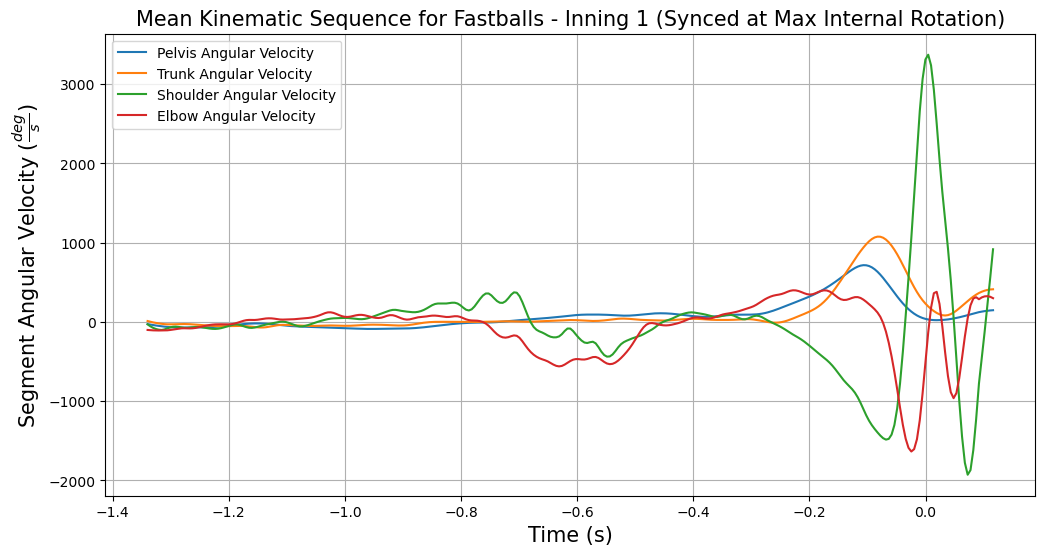

In [8]:
# Filter data for only Fastballs in Inning 1 TEST
inning_1_fastballs = filtered_data_updated[(filtered_data_updated['PITCH_TYPE'] == 'Fastball') & (filtered_data_updated['INNING'] == 1)]

# Create a container to store each pitch's data
all_fastball_data = []

# Iterate through each fastball pitch in Inning 1
for pitch_count in inning_1_fastballs['PITCHER_PITCH_COUNT'].unique():
    single_pitch_data = inning_1_fastballs[inning_1_fastballs['PITCHER_PITCH_COUNT'] == pitch_count]

    # Extract the necessary columns
    t0 = single_pitch_data['ZERO_TIME'].values
    pelvis_ang_z = single_pitch_data['PELVIS_Z'].values
    trunk_ang_z = single_pitch_data['TRUNK_Z'].values
    shoulder_ang_z = single_pitch_data['SHOULDER_Z'].values
    elbow_ang_x = single_pitch_data['ELBOW_X'].values

    # Calculate derivatives
    pelvis_ang_velo = compute_derivative(t0, pelvis_ang_z)
    trunk_ang_velo = compute_derivative(t0, trunk_ang_z)
    shoulder_ang_velo = compute_derivative(t0, shoulder_ang_z)
    elbow_ang_velo = compute_derivative(t0, elbow_ang_x)

    # Apply custom noise filter
    pelvis_ang_velo = apply_custom_filter(pelvis_ang_velo)
    trunk_ang_velo = apply_custom_filter(trunk_ang_velo)
    shoulder_ang_velo = apply_custom_filter(shoulder_ang_velo)
    elbow_ang_velo = apply_custom_filter(elbow_ang_velo)

    # Sync each pitch at Max Internal Rotation
    max_internal_rotation_index = np.argmax(shoulder_ang_velo)
    sync_time = t0 - t0[max_internal_rotation_index]

    # Combine into a structured array
    synced_pitch_data = np.array([sync_time, pelvis_ang_velo, trunk_ang_velo, shoulder_ang_velo, elbow_ang_velo])
    all_fastball_data.append(synced_pitch_data)

# Convert list to a 3D array for easier processing (shape: [pitches, features, time points])
all_fastball_data = np.stack(all_fastball_data)

# Calculate mean values across all fastballs in Inning 1
mean_sync_time = np.mean(all_fastball_data[:, 0, :], axis=0)
mean_pelvis_velo = np.mean(all_fastball_data[:, 1, :], axis=0)
mean_trunk_velo = np.mean(all_fastball_data[:, 2, :], axis=0)
mean_shoulder_velo = np.mean(all_fastball_data[:, 3, :], axis=0)
mean_elbow_velo = np.mean(all_fastball_data[:, 4, :], axis=0)

# Plot the aggregated mean kinematic sequence for Inning 1 Fastballs
plt.figure(figsize=(12, 6))
plt.plot(mean_sync_time, mean_pelvis_velo, label='Pelvis Angular Velocity')
plt.plot(mean_sync_time, mean_trunk_velo, label='Trunk Angular Velocity')
plt.plot(mean_sync_time, mean_shoulder_velo, label='Shoulder Angular Velocity')
plt.plot(mean_sync_time, mean_elbow_velo, label='Elbow Angular Velocity')

plt.xlabel('Time (s)', size=15)
plt.ylabel(r'Segment Angular Velocity ($\frac{deg}{s}$)', size=15)
plt.title('Mean Kinematic Sequence for Fastballs - Inning 1 (Synced at Max Internal Rotation)', size=15)
plt.grid()
plt.legend()
plt.show()


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Create a directory to store the saved plots
output_dir = "/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 2"
os.makedirs(output_dir, exist_ok=True)

# Updated function to save plots instead of displaying them
def save_mean_plots_with_peak_markers(data, pitch_type, inning, segments, output_dir):
    """Creates and saves mean kinematic sequence plots for each pitch type and inning, with peak markers."""
    # Filter data for the selected pitch type and inning
    inning_pitches = data[(data['PITCH_TYPE'] == pitch_type) & (data['INNING'] == inning)]
    
    # Container to store each pitch's data
    all_pitch_data = []
    
    # Iterate through each unique pitch count in the selected pitch type and inning
    for pitch_count in inning_pitches['PITCHER_PITCH_COUNT'].unique():
        single_pitch_data = inning_pitches[inning_pitches['PITCHER_PITCH_COUNT'] == pitch_count]

        # Extract necessary columns
        t0 = single_pitch_data['ZERO_TIME'].values
        pelvis_ang_z = single_pitch_data['PELVIS_Z'].values
        trunk_ang_z = single_pitch_data['TRUNK_Z'].values
        shoulder_ang_z = single_pitch_data['SHOULDER_Z'].values
        elbow_ang_x = single_pitch_data['ELBOW_X'].values

        # Calculate derivatives
        pelvis_ang_velo = compute_derivative(t0, pelvis_ang_z)
        trunk_ang_velo = compute_derivative(t0, trunk_ang_z)
        shoulder_ang_velo = compute_derivative(t0, shoulder_ang_z)
        elbow_ang_velo = compute_derivative(t0, elbow_ang_x)

        # Apply custom noise filter
        pelvis_ang_velo = apply_custom_filter(pelvis_ang_velo)
        trunk_ang_velo = apply_custom_filter(trunk_ang_velo)
        shoulder_ang_velo = apply_custom_filter(shoulder_ang_velo)
        elbow_ang_velo = apply_custom_filter(elbow_ang_velo)

        # Sync each pitch at Max Internal Rotation
        max_internal_rotation_index = np.argmax(shoulder_ang_velo)
        sync_time = t0 - t0[max_internal_rotation_index]

        # Standardize the length of each pitch's time series to a fixed length
        standard_length = 300
        sync_time = sync_time[:standard_length] if len(sync_time) >= standard_length else np.pad(sync_time, (0, standard_length - len(sync_time)), 'constant')
        pelvis_ang_velo = pelvis_ang_velo[:standard_length] if len(pelvis_ang_velo) >= standard_length else np.pad(pelvis_ang_velo, (0, standard_length - len(pelvis_ang_velo)), 'constant')
        trunk_ang_velo = trunk_ang_velo[:standard_length] if len(trunk_ang_velo) >= standard_length else np.pad(trunk_ang_velo, (0, standard_length - len(trunk_ang_velo)), 'constant')
        shoulder_ang_velo = shoulder_ang_velo[:standard_length] if len(shoulder_ang_velo) >= standard_length else np.pad(shoulder_ang_velo, (0, standard_length - len(shoulder_ang_velo)), 'constant')
        elbow_ang_velo = elbow_ang_velo[:standard_length] if len(elbow_ang_velo) >= standard_length else np.pad(elbow_ang_velo, (0, standard_length - len(elbow_ang_velo)), 'constant')

        # Combine into a structured array
        synced_pitch_data = np.array([sync_time, pelvis_ang_velo, trunk_ang_velo, shoulder_ang_velo, elbow_ang_velo])
        all_pitch_data.append(synced_pitch_data)

    # If no data is available for the selected pitch and inning, skip
    if len(all_pitch_data) == 0:
        return

    # Convert list to a 3D array for easier processing (shape: [pitches, features, time points])
    all_pitch_data = np.stack(all_pitch_data)

    # Calculate mean values across all pitches
    mean_sync_time = np.mean(all_pitch_data[:, 0, :], axis=0)
    mean_pelvis_velo = np.mean(all_pitch_data[:, 1, :], axis=0)
    mean_trunk_velo = np.mean(all_pitch_data[:, 2, :], axis=0)
    mean_shoulder_velo = np.mean(all_pitch_data[:, 3, :], axis=0)
    mean_elbow_velo = np.mean(all_pitch_data[:, 4, :], axis=0)

    # Identify peaks for Pelvis, Trunk, Shoulder; identify troughs for Elbow
    pelvis_peak_idx = np.argmax(mean_pelvis_velo)
    trunk_peak_idx = np.argmax(mean_trunk_velo)
    shoulder_peak_idx = np.argmax(mean_shoulder_velo)
    elbow_trough_idx = np.argmin(mean_elbow_velo)

    pelvis_peak = mean_pelvis_velo[pelvis_peak_idx]
    trunk_peak = mean_trunk_velo[trunk_peak_idx]
    shoulder_peak = mean_shoulder_velo[shoulder_peak_idx]
    elbow_trough = mean_elbow_velo[elbow_trough_idx]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(mean_sync_time, mean_pelvis_velo, label=f'Pelvis Angular Velocity (Peak: {pelvis_peak:.2f} deg/s)')
    plt.plot(mean_sync_time, mean_trunk_velo, label=f'Trunk Angular Velocity (Peak: {trunk_peak:.2f} deg/s)')
    plt.plot(mean_sync_time, mean_shoulder_velo, label=f'Shoulder Angular Velocity (Peak: {shoulder_peak:.2f} deg/s)')
    plt.plot(mean_sync_time, mean_elbow_velo, label=f'Elbow Angular Velocity (Trough: {elbow_trough:.2f} deg/s)')

    # Add markers for each identified peak
    plt.scatter(mean_sync_time[pelvis_peak_idx], pelvis_peak, color='blue', s=100, marker='o')
    plt.scatter(mean_sync_time[trunk_peak_idx], trunk_peak, color='orange', s=100, marker='o')
    plt.scatter(mean_sync_time[shoulder_peak_idx], shoulder_peak, color='green', s=100, marker='o')
    plt.scatter(mean_sync_time[elbow_trough_idx], elbow_trough, color='red', s=100, marker='o')

    plt.xlabel('Time (s)', size=15)
    plt.ylabel(r'Segment Angular Velocity ($\frac{deg}{s}$)', size=15)
    plt.title(f'Mean Kinematic Sequence for {pitch_type} - Inning {inning} (Synced at Max Internal Rotation)', size=15)
    plt.grid()
    plt.legend()

    # Save the plot as an image file
    output_filename = f"{pitch_type}_Inning_{inning}_Mean_Kinematic_Sequence.png"
    plt.savefig(os.path.join(output_dir, output_filename))
    plt.close()

# Generate and save mean plots for each pitch type and inning
for pitch_type in ['Fastball', 'Curveball', 'Sinker']:
    for inning in [1, 7]:
        save_mean_plots_with_peak_markers(filtered_data_updated, pitch_type, inning, segments, output_dir)

# Return the directory path for download
output_dir


'/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 2'

In [92]:
# Updated function to ensure proper length synchronization and matching dimensions
def generate_length_corrected_plots(data, pitch_type, inning, segments):
    """Generates combined plots for each pitch type and inning with correct time-length matching and improved display."""
    # Filter data for the selected pitch type and inning
    inning_pitches = data[(data['PITCH_TYPE'] == pitch_type) & (data['INNING'] == inning)]
    
    # Container to store each pitch's data
    all_pitch_data = []
    sync_times = []

    # Define final segment colors based on user preference
    segment_colors = {'Pelvis': 'red', 'Trunk': 'green', 'Shoulder': 'orange', 'Elbow': 'blue'}
    segment_labels = ['Pelvis', 'Trunk', 'Shoulder', 'Elbow']

    # Iterate through each unique pitch count in the selected pitch type and inning
    linestyles = ['-', '--', '-.', ':']
    peak_details = []  # Container to store peak values and times for the table

    for pitch_count in inning_pitches['PITCHER_PITCH_COUNT'].unique():
        single_pitch_data = inning_pitches[inning_pitches['PITCHER_PITCH_COUNT'] == pitch_count]

        # Extract necessary columns
        t0 = single_pitch_data['ZERO_TIME'].values
        pelvis_ang_z = single_pitch_data['PELVIS_Z'].values
        trunk_ang_z = single_pitch_data['TRUNK_Z'].values
        shoulder_ang_z = single_pitch_data['SHOULDER_Z'].values
        elbow_ang_x = single_pitch_data['ELBOW_X'].values

        # Calculate derivatives
        pelvis_ang_velo = compute_derivative(t0, pelvis_ang_z)
        trunk_ang_velo = compute_derivative(t0, trunk_ang_z)
        shoulder_ang_velo = compute_derivative(t0, shoulder_ang_z)
        elbow_ang_velo = compute_derivative(t0, elbow_ang_x)

        # Apply custom noise filter
        pelvis_ang_velo = apply_custom_filter(pelvis_ang_velo)
        trunk_ang_velo = apply_custom_filter(trunk_ang_velo)
        shoulder_ang_velo = apply_custom_filter(shoulder_ang_velo)
        elbow_ang_velo = apply_custom_filter(elbow_ang_velo)

        # Sync each pitch at Max Internal Rotation
        max_internal_rotation_index = np.argmax(shoulder_ang_velo)
        sync_time = t0 - t0[max_internal_rotation_index]

        # Normalize time as a percentage of the pitch sequence
        normalized_time = np.linspace(0, 100, 300)  # Standardize to 300 points for normalization

        # Standardize the length of each pitch's time series to 300 points
        pelvis_ang_velo = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(pelvis_ang_velo)), pelvis_ang_velo)
        trunk_ang_velo = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(trunk_ang_velo)), trunk_ang_velo)
        shoulder_ang_velo = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(shoulder_ang_velo)), shoulder_ang_velo)
        elbow_ang_velo = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(elbow_ang_velo)), elbow_ang_velo)

        # Combine into a structured array
        synced_pitch_data = np.array([pelvis_ang_velo, trunk_ang_velo, shoulder_ang_velo, elbow_ang_velo])
        all_pitch_data.append(synced_pitch_data)
        sync_times.append(normalized_time)

        # Identify individual peaks and their corresponding times
        pitch_peak_values = {
            'Pitch': pitch_count,
            'Pelvis Peak (deg/s)': np.max(pelvis_ang_velo),
            'Pelvis Peak Time (%)': normalized_time[np.argmax(pelvis_ang_velo)],
            'Trunk Peak (deg/s)': np.max(trunk_ang_velo),
            'Trunk Peak Time (%)': normalized_time[np.argmax(trunk_ang_velo)],
            'Shoulder Peak (deg/s)': np.max(shoulder_ang_velo),
            'Shoulder Peak Time (%)': normalized_time[np.argmax(shoulder_ang_velo)],
            'Elbow Trough (deg/s)': np.min(elbow_ang_velo),
            'Elbow Trough Time (%)': normalized_time[np.argmin(elbow_ang_velo)]
        }
        peak_details.append(pitch_peak_values)

    # If no data is available for the selected pitch and inning, skip
    if len(all_pitch_data) == 0:
        return

    # Calculate mean values across all pitches
    all_pitch_data = np.stack(all_pitch_data)  # Shape: [pitches, segments, time points]
    mean_sync_time = np.mean(sync_times, axis=0)
    mean_pelvis_velo = np.mean(all_pitch_data[:, 0, :], axis=0)
    mean_trunk_velo = np.mean(all_pitch_data[:, 1, :], axis=0)
    mean_shoulder_velo = np.mean(all_pitch_data[:, 2, :], axis=0)
    mean_elbow_velo = np.mean(all_pitch_data[:, 3, :], axis=0)

    # Identify peaks for Pelvis, Trunk, Shoulder; identify troughs for Elbow
    pelvis_peak_idx = np.argmax(mean_pelvis_velo)
    trunk_peak_idx = np.argmax(mean_trunk_velo)
    shoulder_peak_idx = np.argmax(mean_shoulder_velo)
    elbow_trough_idx = np.argmin(mean_elbow_velo)

    pelvis_peak = mean_pelvis_velo[pelvis_peak_idx]
    trunk_peak = mean_trunk_velo[trunk_peak_idx]
    shoulder_peak = mean_shoulder_velo[shoulder_peak_idx]
    elbow_trough = mean_elbow_velo[elbow_trough_idx]

    # Function to toggle between mean plot and individual pitches
    def toggle_plot(show_mean):
        plt.figure(figsize=(12, 6))
        if show_mean:
            # Plot only the mean plot
            plt.plot(mean_sync_time, mean_pelvis_velo, color=segment_colors['Pelvis'], label=f'Pelvis Mean (Peak: {pelvis_peak:.2f} deg/s)')
            plt.plot(mean_sync_time, mean_trunk_velo, color=segment_colors['Trunk'], label=f'Trunk Mean (Peak: {trunk_peak:.2f} deg/s)')
            plt.plot(mean_sync_time, mean_shoulder_velo, color=segment_colors['Shoulder'], label=f'Shoulder Mean (Peak: {shoulder_peak:.2f} deg/s)')
            plt.plot(mean_sync_time, mean_elbow_velo, color=segment_colors['Elbow'], label=f'Elbow Mean (Trough: {elbow_trough:.2f} deg/s)')

            # Add markers for each identified peak/trough
            plt.scatter(mean_sync_time[pelvis_peak_idx], pelvis_peak, color=segment_colors['Pelvis'], s=100, marker='o')
            plt.scatter(mean_sync_time[trunk_peak_idx], trunk_peak, color=segment_colors['Trunk'], s=100, marker='o')
            plt.scatter(mean_sync_time[shoulder_peak_idx], shoulder_peak, color=segment_colors['Shoulder'], s=100, marker='o')
            plt.scatter(mean_sync_time[elbow_trough_idx], elbow_trough, color=segment_colors['Elbow'], s=100, marker='o')
        else:
            # Plot each individual pitch with different linestyles
            for idx, (pitch_data, sync_time) in enumerate(zip(all_pitch_data, sync_times)):
                linestyle = linestyles[idx % len(linestyles)]  # Cycle through defined linestyles
                for seg_idx, segment in enumerate(segment_labels):
                    plt.plot(sync_time, pitch_data[seg_idx, :], linestyle=linestyle, color=segment_colors[segment], alpha=0.5)

            # Display the peak values and aåtimes as a table below the plot
            peak_df = pd.DataFrame(peak_details)
            display(peak_df)

        # Only display the four segments in the legend
        handles = [
        plt.Line2D([0], [0], color=segment_colors['Pelvis'], linestyle='-', lw=2, label=f'Pelvis Velocity (Mean Peak: {pelvis_peak:.2f} deg/s)'),
        plt.Line2D([0], [0], color=segment_colors['Trunk'], linestyle='-', lw=2, label=f'Trunk Velocity (Mean Peak: {trunk_peak:.2f} deg/s)'),
        plt.Line2D([0], [0], color=segment_colors['Shoulder'], linestyle='-', lw=2, label=f'Shoulder Velocity (Mean Peak: {shoulder_peak:.2f} deg/s)'),
        plt.Line2D([0], [0], color=segment_colors['Elbow'], linestyle='-', lw=2, label=f'Elbow Velocity (Mean Trough: {elbow_trough:.2f} deg/s)')
        ]
        plt.legend(handles=handles, loc='upper left')
        plt.xlabel('Time (% of Pitch Delivery)', size=15)
        plt.ylabel(r'Segment Angular Velocity ($\frac{deg}{s}$)', size=15)
        plt.title(f'Kinematic Sequence for {pitch_type} - Inning {inning}', size=15)
        plt.grid()
        plt.show()

    # Create a toggle button to switch between views
    toggle_btn = ToggleButton(value=False, description="Show Mean Plot")
    interactive_plot = interactive(toggle_plot, show_mean=toggle_btn)
    return interactive_plot

# Generate interactive plot with corrected dimensions and normalization
interactive_plot = generate_length_corrected_plots(filtered_data_updated, 'Fastball', 1, segments)
interactive_plot


interactive(children=(ToggleButton(value=False, description='Show Mean Plot'), Output()), _dom_classes=('widge…

      INNING PITCHER_PITCH_COUNT PITCHER_NAME_LAST_FIRST PITCH_TYPE  FRAME  \
1          1                  12                Player A  Curveball      2   
2          1                  12                Player A  Curveball      3   
3          1                  12                Player A  Curveball      4   
4          1                  12                Player A  Curveball      5   
5          1                  12                Player A  Curveball      6   
...      ...                 ...                     ...        ...    ...   
8122       7                 102                Player A   Fastball    297   
8123       7                 102                Player A   Fastball    298   
8124       7                 102                Player A   Fastball    299   
8125       7                 102                Player A   Fastball    300   
8126       7                 102                Player A   Fastball    301   

      ZERO_TIME  BACKHIP_Z  BACKKNEE_X  MODEL_COG_LAB_X  MODEL_

In [142]:

def generate_length_corrected_plots(data, pitch_type, inning, segments):
    """Generates combined plots for each pitch type and inning with correct time-length matching and improved display."""

   # Filter data for the selected pitch type and inning
    inning_pitches = data[(data['PITCH_TYPE'] == pitch_type) & (data['INNING'] == inning)]


    all_pitch_data = []
    sync_times = []

    # Define final segment colors and labels
    segment_colors = {'Pelvis': 'red', 'Trunk': 'green', 'Shoulder': 'orange', 'Elbow': 'blue'}
    segment_labels = ['Pelvis', 'Trunk', 'Shoulder', 'Elbow']

    linestyles = ['-', '--', '-.', ':']
    peak_details = []  # Container to store peak values and times for individual pitches

    for pitch_count in inning_pitches['PITCHER_PITCH_COUNT'].unique():
        
        single_pitch_data = inning_pitches[inning_pitches['PITCHER_PITCH_COUNT'] == pitch_count]

        # Extract necessary columns
        t0 = single_pitch_data['ZERO_TIME'].values
        pelvis_ang_z = single_pitch_data['PELVIS_Z'].values
        trunk_ang_z = single_pitch_data['TRUNK_Z'].values
        shoulder_ang_z = single_pitch_data['SHOULDER_Z'].values
        elbow_ang_x = single_pitch_data['ELBOW_X'].values

        # Calculate derivatives
        pelvis_ang_velo = compute_derivative(t0, pelvis_ang_z)
        trunk_ang_velo = compute_derivative(t0, trunk_ang_z)
        shoulder_ang_velo = compute_derivative(t0, shoulder_ang_z)
        elbow_ang_velo = compute_derivative(t0, elbow_ang_x)

        # Apply custom noise filter
        pelvis_ang_velo = apply_custom_filter(pelvis_ang_velo)
        trunk_ang_velo = apply_custom_filter(trunk_ang_velo)
        shoulder_ang_velo = apply_custom_filter(shoulder_ang_velo)
        elbow_ang_velo = apply_custom_filter(elbow_ang_velo)

        # Sync each pitch at Max Internal Rotation
        max_internal_rotation_index = np.argmax(shoulder_ang_velo)
        sync_time = t0 - t0[max_internal_rotation_index]

        # Normalize time as a percentage of the pitch sequence
        normalized_time = np.linspace(0, 100, 300)

        # Standardize the length of each pitch's time series to 300 points
        pelvis_ang_velo = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(pelvis_ang_velo)), pelvis_ang_velo)
        trunk_ang_velo = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(trunk_ang_velo)), trunk_ang_velo)
        shoulder_ang_velo = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(shoulder_ang_velo)), shoulder_ang_velo)
        elbow_ang_velo = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(elbow_ang_velo)), elbow_ang_velo)

        # Combine into a structured array
        synced_pitch_data = np.array([pelvis_ang_velo, trunk_ang_velo, shoulder_ang_velo, elbow_ang_velo])
        all_pitch_data.append(synced_pitch_data)
        sync_times.append(normalized_time)

        # Store peak details for individual pitches
        pitch_peak_values = {
            'Pitch': pitch_count,
            'Pelvis Peak (deg/s)': np.max(pelvis_ang_velo),
            'Pelvis Peak Time (%)': normalized_time[np.argmax(pelvis_ang_velo)],
            'Trunk Peak (deg/s)': np.max(trunk_ang_velo),
            'Trunk Peak Time (%)': normalized_time[np.argmax(trunk_ang_velo)],
            'Shoulder Peak (deg/s)': np.max(shoulder_ang_velo),
            'Shoulder Peak Time (%)': normalized_time[np.argmax(shoulder_ang_velo)],
            'Elbow Trough (deg/s)': np.min(elbow_ang_velo),
            'Elbow Trough Time (%)': normalized_time[np.argmin(elbow_ang_velo)]
        }
        peak_details.append(pitch_peak_values)

    # If no data is available for the selected pitch and inning, skip
    if len(all_pitch_data) == 0:
        return

    # Calculate mean and standard deviation across all pitches
    all_pitch_data = np.stack(all_pitch_data)  # Shape: [pitches, segments, time points]
    mean_sync_time = np.mean(sync_times, axis=0)
    
    
    # Store mean and standard deviation in a dictionary
    mean_std_dict = {}
    for i, segment in enumerate(segment_labels):
        mean_std_dict[segment] = (np.mean(all_pitch_data[:, i, :], axis=0), np.std(all_pitch_data[:, i, :], axis=0))
       
        
    # Identify peaks and troughs from the mean data
    peak_values = {}
    peak_times = {}
    for segment in segment_labels:
        if segment == 'Elbow':
            peak_values[segment] = np.min(mean_std_dict[segment][0])  # Trough for Elbow
            peak_times[segment] = np.argmin(mean_std_dict[segment][0])
        else:
            peak_values[segment] = np.max(mean_std_dict[segment][0])
            peak_times[segment] = np.argmax(mean_std_dict[segment][0])
    
    # Function to toggle between mean plot and individual pitches
    def toggle_plot(show_mean):
        fig, ax = plt.subplots()
        
        if show_mean:
            # Plot only the mean plot with standard deviations and peak markers
            for segment, color in segment_colors.items():
                mean_velo, std_velo = mean_std_dict[segment]
                ax.plot(mean_sync_time, mean_velo, color=color, label=f'{segment} Mean (Peak: {peak_values[segment]:.2f} deg/s)')
                ax.fill_between(mean_sync_time, mean_velo - std_velo, mean_velo + std_velo, color=color, alpha=0.2)

            # Add scatter markers for mean peaks and troughs
            for segment in segment_labels:
                ax.scatter(mean_sync_time[peak_times[segment]], peak_values[segment], color=segment_colors[segment], s=100, marker='o')

            # Create a table dynamically for mean peak values
            table_data = [['Segment', 'Peak Value (deg/s)', 'Time of Peak (%)']]
            for segment in segment_labels:
                table_data.append([segment, f'{peak_values[segment]:.2f}', f'{mean_sync_time[peak_times[segment]]:.2f}'])

            ax.table(cellText=table_data, cellLoc='center', loc='top', bbox=[0, 1.1, 1, 0.3])
            ax.legend(loc='upper left')
        else:
            # Plot each individual pitch with different linestyles
            for idx, (pitch_data, sync_time) in enumerate(zip(all_pitch_data, sync_times)):
                linestyle = linestyles[idx % len(linestyles)]
                for seg_idx, segment in enumerate(segment_labels):
                    ax.plot(sync_time, pitch_data[seg_idx, :], linestyle=linestyle, color=segment_colors[segment], alpha=0.5)
        # Create and display a DataFrame table for individual pitch peaks   
            peak_df = pd.DataFrame(peak_details)
            display(peak_df)
            

        plt.xlabel('Time (% of Pitch Delivery)', size=15)
        plt.ylabel(r'Segment Angular Velocity ($\frac{deg}{s}$)', size=15)
        plt.title(f'Kinematic Sequence with SD for {pitch_type} - Inning {inning}', size=15)
        plt.grid()
        
            
    # Create a toggle button to switch between views
    toggle_btn = ToggleButton(value=False, description="Show Mean Plot")
    interactive_plot = interactive(toggle_plot, show_mean=toggle_btn)
    display(interactive_plot)
    return interactive_plot
    
# Example usage
interactive_plot = generate_length_corrected_plots(filtered_data_updated, 'Fastball', 1, segments)



interactive(children=(ToggleButton(value=False, description='Show Mean Plot'), Output()), _dom_classes=('widge…

In [153]:
# Define a list of pitch types and innings to iterate through
pitch_types = ['Fastball', 'Curveball', 'Sinker']  # Add other pitch types if needed
innings = [1, 7]  # Add more innings if necessary

# Loop through each pitch type and inning to generate plots
for pitch_type in pitch_types:
    for inning in innings:
        print(f"Generating plot for {pitch_type} - Inning {inning}")

        # Generate interactive plot with corrected dimensions and normalization for each pitch type and inning
        interactive_plot = generate_length_corrected_plots(filtered_data_updated, pitch_type, inning, segments)
        
        # Display the generated plot if available, otherwise, print a message
        '''if interactive_plot:
            display(interactive_plot)  # Use display to show each interactive plot
            plt.figure()
        else:'''
            #print(f"No data available for {pitch_type} - Inning {inning}")


Generating plot for Fastball - Inning 1


interactive(children=(ToggleButton(value=False, description='Show Mean Plot'), Output()), _dom_classes=('widge…

Generating plot for Fastball - Inning 7


interactive(children=(ToggleButton(value=False, description='Show Mean Plot'), Output()), _dom_classes=('widge…

Generating plot for Curveball - Inning 1


interactive(children=(ToggleButton(value=False, description='Show Mean Plot'), Output()), _dom_classes=('widge…

Generating plot for Curveball - Inning 7


interactive(children=(ToggleButton(value=False, description='Show Mean Plot'), Output()), _dom_classes=('widge…

Generating plot for Sinker - Inning 1
Generating plot for Sinker - Inning 7


interactive(children=(ToggleButton(value=False, description='Show Mean Plot'), Output()), _dom_classes=('widge…

QUESTION 3



Column 'Mean_Pitch_Velocity' not found in the data. Skipping metric 'Pitch_Velocity'.
Column 'Mean_Spin_Rate' not found in the data. Skipping metric 'Spin_Rate'.


,Metric,First Inning Mean,Last Inning Mean,p-value,Significance
0,Pelvis,773.507529,801.178872,0.011921,Significant
1,Trunk,1134.281926,1118.199016,0.153228,Not Significant
2,Shoulder,4831.823603,4580.938632,0.220662,Not Significant
3,Elbow,-2433.495907,-2453.744472,0.745966,Not Significant


     Metric  First Inning Mean  Last Inning Mean   p-value     Significance
0    Pelvis         773.507529        801.178872  0.011921      Significant
1     Trunk        1134.281926       1118.199016  0.153228  Not Significant
2  Shoulder        4831.823603       4580.938632  0.220662  Not Significant
3     Elbow       -2433.495907      -2453.744472  0.745966  Not Significant


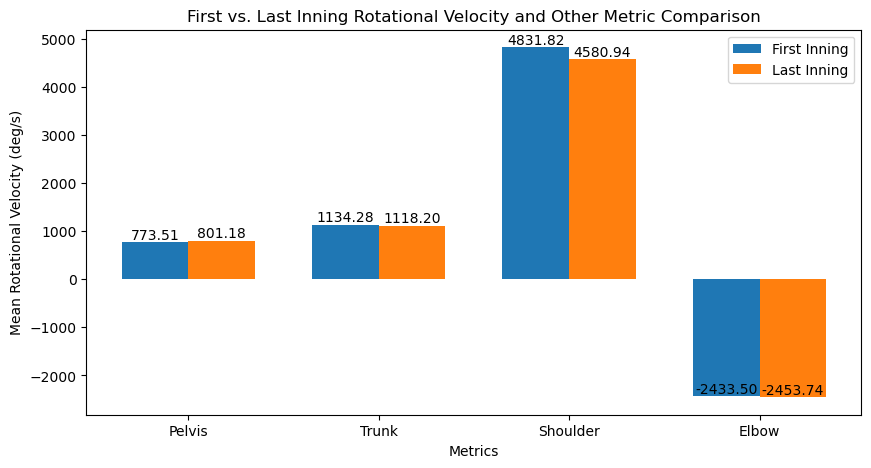

,Metric,First Inning Mean,Last Inning Mean,p-value,Significance
0,Pelvis,773.507529,801.178872,0.011921,Significant
1,Trunk,1134.281926,1118.199016,0.153228,Not Significant
2,Shoulder,4831.823603,4580.938632,0.220662,Not Significant
3,Elbow,-2433.495907,-2453.744472,0.745966,Not Significant


In [158]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

# Function to compute peak values and additional metrics for each pitch
def compute_peak_values(data):
    """
    Compute peak rotational velocities and add pitch velocity and spin rate as columns.
    """
    # Columns to include in the peak calculation
    columns_to_include = {
        'Pelvis_Rotational_Velocity': 'max',
        'Trunk_Rotational_Velocity': 'max',
        'Shoulder_Internal_Rotation_Velocity': 'max',
        'Elbow_Extension_Velocity': 'min'
    }
    
    # Dynamically add Pitch_Velocity and Spin_Rate if they are in the dataset
    if 'Pitch_Velocity' in data.columns:
        columns_to_include['Pitch_Velocity'] = 'mean'
    if 'Spin_Rate' in data.columns:
        columns_to_include['Spin_Rate'] = 'mean'
    
    # Group by and compute the peak values
    peak_data = data.groupby(['INNING', 'PITCHER_PITCH_COUNT']).agg(columns_to_include).reset_index()
    
    # Rename columns to match the expected format for easier referencing
    peak_data.rename(columns={
        'Pelvis_Rotational_Velocity': 'Peak_Pelvis_Rotational_Velocity',
        'Trunk_Rotational_Velocity': 'Peak_Trunk_Rotational_Velocity',
        'Shoulder_Internal_Rotation_Velocity': 'Peak_Shoulder_Rotational_Velocity',
        'Elbow_Extension_Velocity': 'Peak_Elbow_Rotational_Velocity',
        'Pitch_Velocity': 'Mean_Pitch_Velocity',
        'Spin_Rate': 'Mean_Spin_Rate'
    }, inplace=True)
    
    return peak_data

# Function to calculate statistical difference between first and last innings
def calculate_statistical_difference(data, pitch_type, metrics=['Pelvis', 'Trunk', 'Shoulder', 'Elbow', 'Pitch_Velocity', 'Spin_Rate']):
    """
    Calculates statistical differences between first and last innings for key metrics.
    """
    # Compute the peak values for the given data
    peak_data = compute_peak_values(data)
    
    # Filter data for the selected pitch type and only use peak values DataFrame
    peak_data = peak_data[peak_data['INNING'].isin([1, 7])]
    
    # Extract first and last inning data
    first_inning_data = peak_data[peak_data['INNING'] == 1]
    last_inning_data = peak_data[peak_data['INNING'] == 7]
    
    # Ensure we have equal sample sizes by matching the larger sample to the smaller one
    if len(first_inning_data) != len(last_inning_data):
        smaller_size = min(len(first_inning_data), len(last_inning_data))
        first_inning_data = first_inning_data.sample(n=smaller_size, random_state=1)
        last_inning_data = last_inning_data.sample(n=smaller_size, random_state=1)
    
    # Initialize containers for results
    stat_results = {'Metric': [], 'First Inning Mean': [], 'Last Inning Mean': [],
                    'p-value': [], 'Significance': []}

    # Loop through each metric and calculate differences
    for metric in metrics:
        # Define the correct column names based on metric
        if metric == 'Pelvis':
            col_name = 'Peak_Pelvis_Rotational_Velocity'
        elif metric == 'Trunk':
            col_name = 'Peak_Trunk_Rotational_Velocity'
        elif metric == 'Shoulder':
            col_name = 'Peak_Shoulder_Rotational_Velocity'
        elif metric == 'Elbow':
            col_name = 'Peak_Elbow_Rotational_Velocity'
        elif metric == 'Pitch_Velocity':
            col_name = 'Mean_Pitch_Velocity'
        elif metric == 'Spin_Rate':
            col_name = 'Mean_Spin_Rate'
        else:
            continue

        # Check if the column exists in the data
        if col_name not in first_inning_data.columns or col_name not in last_inning_data.columns:
            print(f"Column '{col_name}' not found in the data. Skipping metric '{metric}'.")
            continue

        # Extract peak values for the given metric
        first_inning_peaks = first_inning_data[col_name].dropna()
        last_inning_peaks = last_inning_data[col_name].dropna()
        
        
        # Calculate paired t-test
        t_stat, p_val = ttest_rel(first_inning_peaks, last_inning_peaks)
            
        # Store results
        stat_results['Metric'].append(metric)
        stat_results['First Inning Mean'].append(np.mean(first_inning_peaks))
        stat_results['Last Inning Mean'].append(np.mean(last_inning_peaks))
        stat_results['p-value'].append(p_val)
        stat_results['Significance'].append('Significant' if p_val < 0.05 else 'Not Significant')
    
    # Convert results into a DataFrame
    stat_df = pd.DataFrame(stat_results)
    display(stat_df)
    # Display the statistical results
    print(stat_df)

    # Plot the results
    plot_statistical_comparison(stat_df)

    return stat_df

# Function to visualize the comparison between first and last inning metrics
def plot_statistical_comparison(stat_df):
    """
    Plots a comparison of first and last inning mean values for each metric.
    """
    fig, ax = plt.subplots(figsize=(10,5))
    width = 0.35  # Width of the bars

    # Separate rotational velocity metrics and others (e.g., Pitch Velocity and Spin Rate)
    rotational_metrics = ['Pelvis', 'Trunk', 'Shoulder', 'Elbow']
    other_metrics = ['Pitch_Velocity', 'Spin_Rate']
    
    # Plot rotational velocity metrics on the left y-axis
    x = np.arange(len(stat_df['Metric']))
    rotational_df = stat_df[stat_df['Metric'].isin(rotational_metrics)]
    bars1 = ax.bar(rotational_df.index - width/2, rotational_df['First Inning Mean'], width, label='First Inning')
    bars2 = ax.bar(rotational_df.index + width/2, rotational_df['Last Inning Mean'], width, label='Last Inning')

    # Plot non-rotational metrics on a secondary y-axis (if they exist)
    if len(stat_df[stat_df['Metric'].isin(other_metrics)]) > 0:
        ax2 = ax.twinx()  # Create a secondary y-axis
        other_df = stat_df[stat_df['Metric'].isin(other_metrics)]
        ax2.bar(other_df.index - width/2, other_df['First Inning Mean'], width, label='First Inning', color='orange')
        ax2.bar(other_df.index + width/2, other_df['Last Inning Mean'], width, label='Last Inning', color='green')
        ax2.set_ylabel('Mean Value (Pitch Velocity, Spin Rate)')

    # Add labels and legend
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Mean Rotational Velocity (deg/s)')
    ax.set_title('First vs. Last Inning Rotational Velocity and Other Metric Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(stat_df['Metric'])
    ax.legend()

    # Attach text labels above each bar
    for bar in bars1 + bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.show()

# Example usage
calculate_statistical_difference(filtered_data_updated, 'Fastball', metrics=['Pelvis', 'Trunk', 'Shoulder', 'Elbow', 'Pitch_Velocity', 'Spin_Rate'])


In [159]:


# Define the path to your Excel file
stats_path = r'/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 3/stats.xlsm'

# Try to read the file and list all available sheet names
try:
    # Load the workbook
    excel_file = pd.ExcelFile(stats_path)
    
    # Print the available sheet names to find the correct one
    print("Available sheet names:", excel_file.sheet_names)
    
    # Use the correct sheet name from the printed list
    sheet_name = 'Sheet1'  # Replace 'Sheet1' with the correct name
    
    # Load the desired sheet into a DataFrame
    stats_df = pd.read_excel(stats_path, sheet_name=sheet_name)
    
    # Display the first few rows to verify data
    print(stats_df.head())
except FileNotFoundError:
    print(f"Error: File not found at the specified path: {stats_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Available sheet names: ['Sheet1']
   INNING PITCH_TYPE  Mean_Pitch_Velocity  Std_Pitch_Velocity  Mean_Spin_Rate  \
0       1  Curveball            82.260517            0.559430     2955.646667   
1       1   Fastball            95.544671            0.857512     2233.980000   
2       7   Changeup            86.450300            0.000000     1999.980000   
3       7  Curveball            80.970660            0.587149     2999.780000   
4       7   Fastball            93.642100            0.497514     2278.180000   

   Std_Spin_Rate  Peak_Shoulder_Internal_Rotation_Velocity_Mean  \
0      88.802402                                    4917.430614   
1      68.551684                                    4740.543546   
2       0.000000                                            NaN   
3      62.291251                                    4792.029595   
4      40.493209                                    4298.602221   

   Peak_Shoulder_Internal_Rotation_Velocity_Std  \
0                        

     Metric  First Inning Mean  Last Inning Mean   p-value  Cohen's d  \
0    Pelvis         773.507529        801.178872  0.011921  -1.624212   
1     Trunk        1134.281926       1118.199016  0.153228   0.793263   
2  Shoulder        4831.823603       4580.938632  0.220662   0.753880   
3     Elbow       -2433.495907      -2453.744472  0.745966   0.149196   

      Significance  
0      Significant  
1  Not Significant  
2  Not Significant  
3  Not Significant  


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


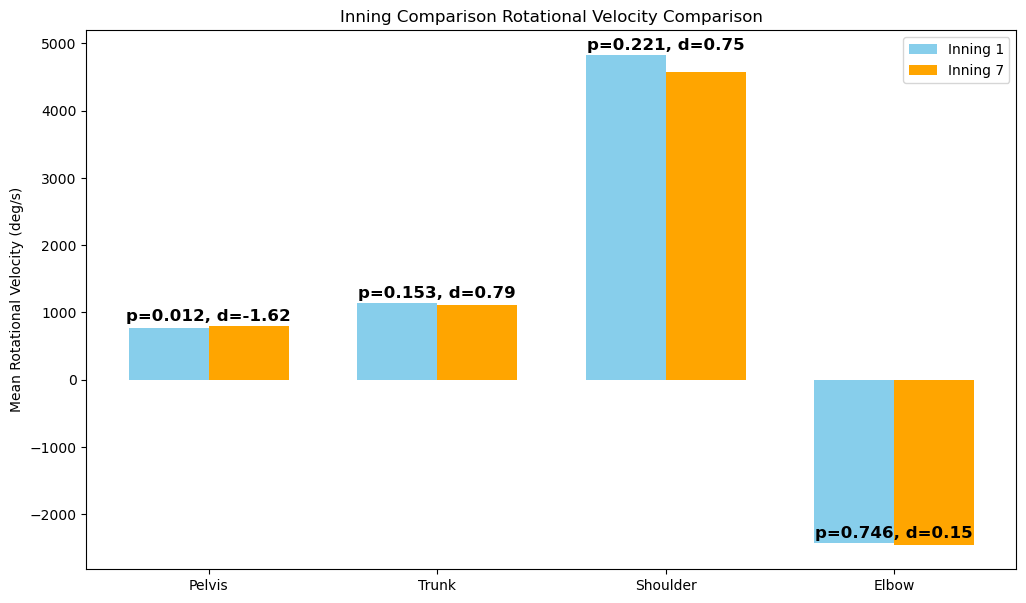

Saved: Inning Comparison_Rotational_Velocity_Comparison.png


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/485131508.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='INNING', y=metric, data=filtered_data, palette="muted", width=0.5)


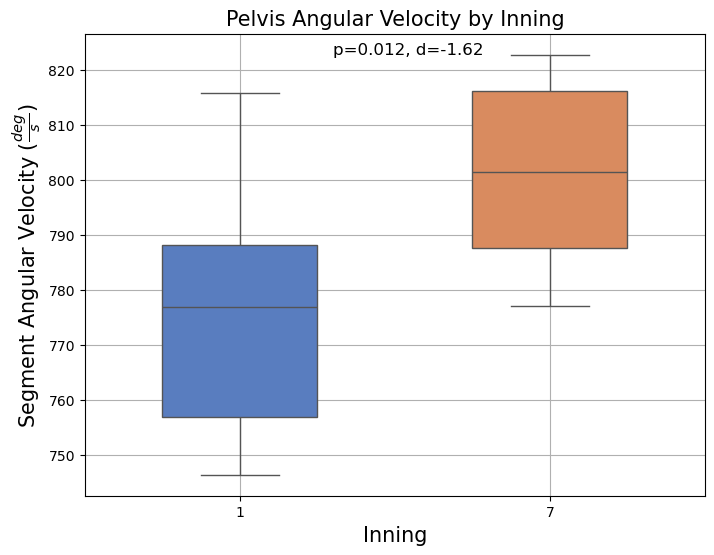

Saved: BoxPlot_Peak_Pelvis_Rotational_Velocity_by_Inning.png


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/485131508.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='INNING', y=metric, data=filtered_data, palette="muted", width=0.5)


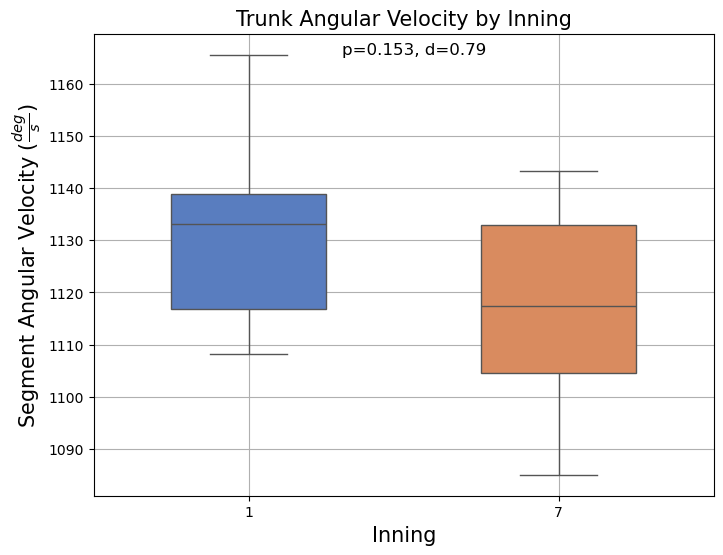

Saved: BoxPlot_Peak_Trunk_Rotational_Velocity_by_Inning.png


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/485131508.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='INNING', y=metric, data=filtered_data, palette="muted", width=0.5)


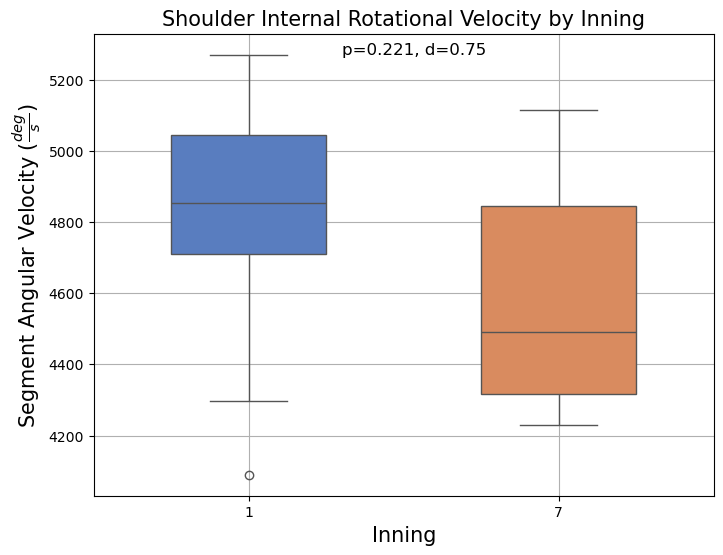

Saved: BoxPlot_Peak_Shoulder_Rotational_Velocity_by_Inning.png


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/485131508.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='INNING', y=metric, data=filtered_data, palette="muted", width=0.5)


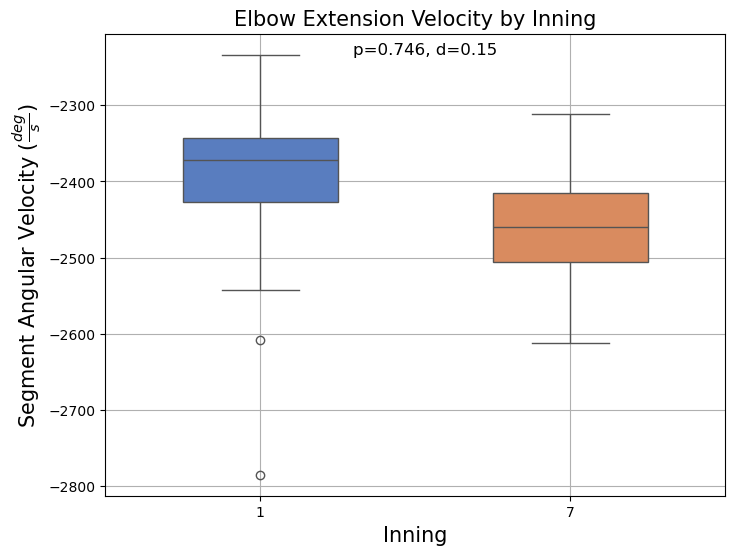

Saved: BoxPlot_Peak_Elbow_Rotational_Velocity_by_Inning.png


,Metric,First Inning Mean,Last Inning Mean,p-value,Cohen's d,Significance
0,Pelvis,773.507529,801.178872,0.011921,-1.624212,Significant
1,Trunk,1134.281926,1118.199016,0.153228,0.793263,Not Significant
2,Shoulder,4831.823603,4580.938632,0.220662,0.753880,Not Significant
3,Elbow,-2433.495907,-2453.744472,0.745966,0.149196,Not Significant


In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, sem

# Function to compute Cohen's d for effect size
def cohen_d(x, y):
    """Calculate Cohen's d for two samples."""
    n1, n2 = len(x), len(y)
    pooled_std = np.sqrt(((n1 - 1) * np.var(x, ddof=1) + (n2 - 1) * np.var(y, ddof=1)) / (n1 + n2 - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

# Function to compute peak values for each pitch and additional metrics
def compute_peak_values(data):
    columns_to_include = {
        'Pelvis_Rotational_Velocity': 'max',
        'Trunk_Rotational_Velocity': 'max',
        'Shoulder_Internal_Rotation_Velocity': 'max',
        'Elbow_Extension_Velocity': 'min'
    }
    
    peak_data = data.groupby(['INNING', 'PITCHER_PITCH_COUNT']).agg(columns_to_include).reset_index()
    peak_data.rename(columns={
        'Pelvis_Rotational_Velocity': 'Peak_Pelvis_Rotational_Velocity',
        'Trunk_Rotational_Velocity': 'Peak_Trunk_Rotational_Velocity',
        'Shoulder_Internal_Rotation_Velocity': 'Peak_Shoulder_Rotational_Velocity',
        'Elbow_Extension_Velocity': 'Peak_Elbow_Rotational_Velocity'
    }, inplace=True)
    
    return peak_data

# Function to calculate statistical differences
def calculate_statistical_difference(data, metrics=['Pelvis', 'Trunk', 'Shoulder', 'Elbow']):
    peak_data = compute_peak_values(data)
    peak_data = peak_data[peak_data['INNING'].isin([1, 7])]
    first_inning_data = peak_data[peak_data['INNING'] == 1]
    last_inning_data = peak_data[peak_data['INNING'] == 7]

    # Equalize sample sizes for statistical test
    if len(first_inning_data) != len(last_inning_data):
        smaller_size = min(len(first_inning_data), len(last_inning_data))
        first_inning_data = first_inning_data.sample(n=smaller_size, random_state=1)
        last_inning_data = last_inning_data.sample(n=smaller_size, random_state=1)
    
    stat_results = {'Metric': [], 'First Inning Mean': [], 'Last Inning Mean': [], 'p-value': [], 'Cohen\'s d': [], 'Significance': []}
    
    for metric in metrics:
        col_name = f'Peak_{metric}_Rotational_Velocity'
        
        if col_name not in first_inning_data.columns or col_name not in last_inning_data.columns:
            print(f"Column '{col_name}' not found. Skipping '{metric}'")
            continue

        first_inning_peaks = first_inning_data[col_name].dropna()
        last_inning_peaks = last_inning_data[col_name].dropna()
        t_stat, p_val = ttest_rel(first_inning_peaks, last_inning_peaks)
        d = cohen_d(first_inning_peaks, last_inning_peaks)  # Calculate Cohen's d for effect size
        
        # Store results
        stat_results['Metric'].append(metric)
        stat_results['First Inning Mean'].append(np.mean(first_inning_peaks))
        stat_results['Last Inning Mean'].append(np.mean(last_inning_peaks))
        stat_results['p-value'].append(p_val)
        stat_results['Cohen\'s d'].append(d)
        stat_results['Significance'].append('Significant' if p_val < 0.05 else 'Not Significant')

    stat_df = pd.DataFrame(stat_results)
    print(stat_df)

    # Plot bar charts with CIs and generate box plots
    plot_comparison_plots(stat_df, title_prefix='Inning Comparison')
    generate_combined_box_plots(peak_data, metrics, stat_df)
    
    return stat_df

# Function to plot bar comparison charts with statistics annotations
def plot_comparison_plots(stat_df, title_prefix=''):
    fig, ax = plt.subplots(figsize=(12, 7))
    width = 0.35  # Bar width

    # Means and standard errors for CIs
    first_means = stat_df['First Inning Mean']
    last_means = stat_df['Last Inning Mean']
    first_stds = stat_df['First Inning Mean'].apply(lambda x: sem([x]))
    last_stds = stat_df['Last Inning Mean'].apply(lambda x: sem([x]))

    # Bar plot with CIs
    x = np.arange(len(stat_df['Metric']))
    bars1 = ax.bar(x - width/2, first_means, width, label='Inning 1', yerr=first_stds, capsize=5, color='skyblue')
    bars2 = ax.bar(x + width/2, last_means, width, label='Inning 7', yerr=last_stds, capsize=5, color='orange')

    # Adding annotations for p-values and Cohen's d on top of bars
    for idx, (bar1, bar2, p_val, d_val) in enumerate(zip(bars1, bars2, stat_df['p-value'], stat_df['Cohen\'s d'])):
        # Find midpoint between the bars
        midpoint = (bar1.get_x() + bar2.get_x() + bar2.get_width()) / 2
        ax.text(midpoint, max(bar1.get_height(), bar2.get_height()) + 30, f"p={p_val:.3f}, d={d_val:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax.set_title(f'{title_prefix} Rotational Velocity Comparison')
    ax.set_ylabel('Mean Rotational Velocity (deg/s)')
    ax.set_xticks(x)
    ax.set_xticklabels(stat_df['Metric'])
    ax.legend()

    # Save the plot
    plt.savefig(f"{title_prefix}_Rotational_Velocity_Comparison.png")
    plt.show()
    print(f"Saved: {title_prefix}_Rotational_Velocity_Comparison.png")

# Function to generate combined box plots with annotations
def generate_combined_box_plots(data, metrics, stat_df):
    metric_names = {'Peak_Pelvis_Rotational_Velocity': 'Pelvis Angular Velocity',
                    'Peak_Trunk_Rotational_Velocity': 'Trunk Angular Velocity',
                    'Peak_Shoulder_Rotational_Velocity': 'Shoulder Internal Rotational Velocity',
                    'Peak_Elbow_Rotational_Velocity': 'Elbow Extension Velocity'}
    
    filtered_data = data[['INNING'] + [f'Peak_{metric}_Rotational_Velocity' for metric in metrics]]

    # Generate box plots for each metric across innings
    for metric in filtered_data.columns[1:]:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='INNING', y=metric, data=filtered_data, palette="muted", width=0.5)

        # Extract relevant p-values and Cohen's d for the boxplot
        metric_key = metric.split('_')[1]
        p_value = stat_df.loc[stat_df['Metric'] == metric_key, 'p-value'].values
        cohen_d_val = stat_df.loc[stat_df['Metric'] == metric_key, 'Cohen\'s d'].values
        if len(p_value) > 0 and len(cohen_d_val) > 0:
            plt.text(0.3, filtered_data[metric].max(), f"p={p_value[0]:.3f}, d={cohen_d_val[0]:.2f}", fontsize=12)

        plt.title(f'{metric_names.get(metric, metric)} by Inning', size=15)
        plt.xlabel('Inning', size = 15)
        plt.ylabel(r'Segment Angular Velocity ($\frac{deg}{s}$)', size=15)
        plt.grid(True)

        # Save the plot
        output_filename = f'BoxPlot_{metric}_by_Inning.png'
        plt.savefig(output_filename)
        plt.show()
        print(f"Saved: {output_filename}")

# Example usage
calculate_statistical_difference(filtered_data_updated)


Generating plots for Curveball...


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/423177621.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/423177621.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='INNING', y=metric, data=pitch_data, palette="Set3")


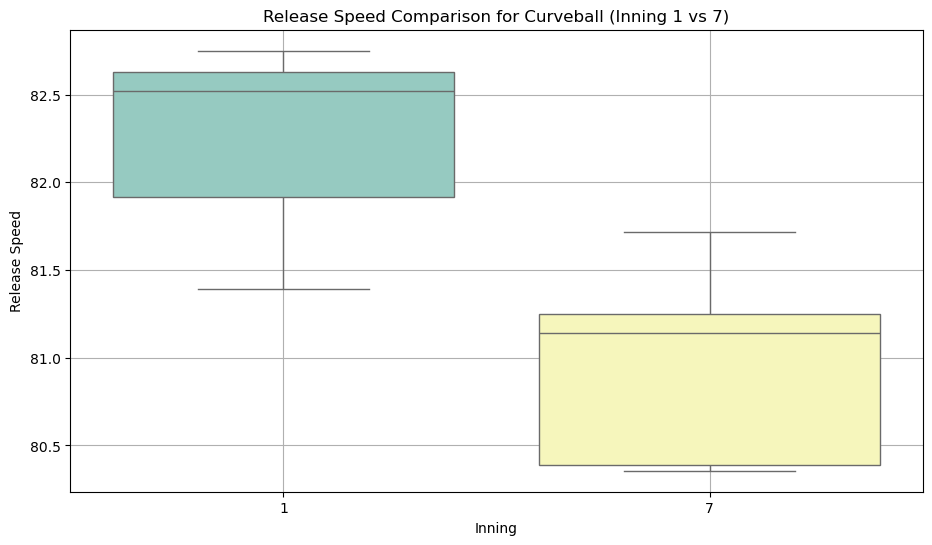

Saved: Curveball_RELEASE_SPEED_Inning_Comparison.png


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/423177621.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='INNING', y=metric, data=pitch_data, palette="Set3")


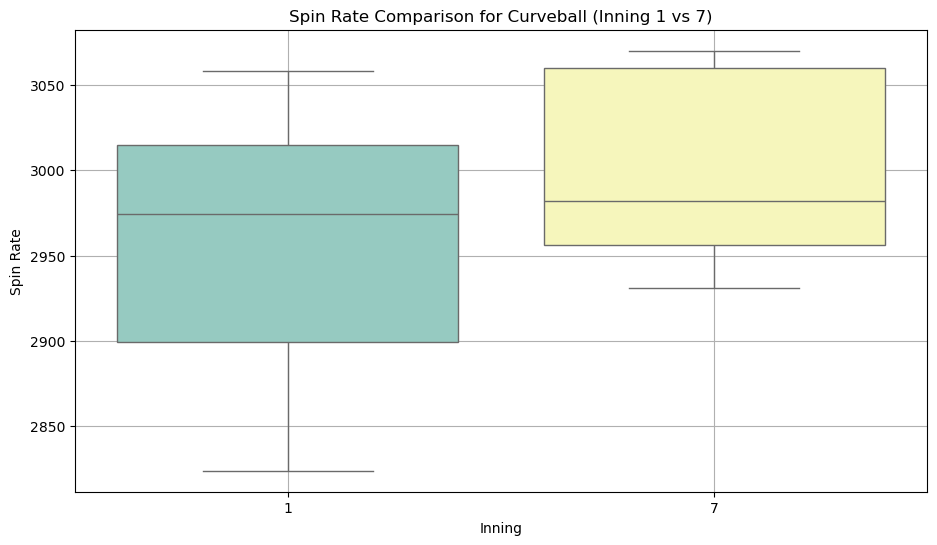

Saved: Curveball_SPIN_RATE_Inning_Comparison.png
Generating plots for Fastball...


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/423177621.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='INNING', y=metric, data=pitch_data, palette="Set3")


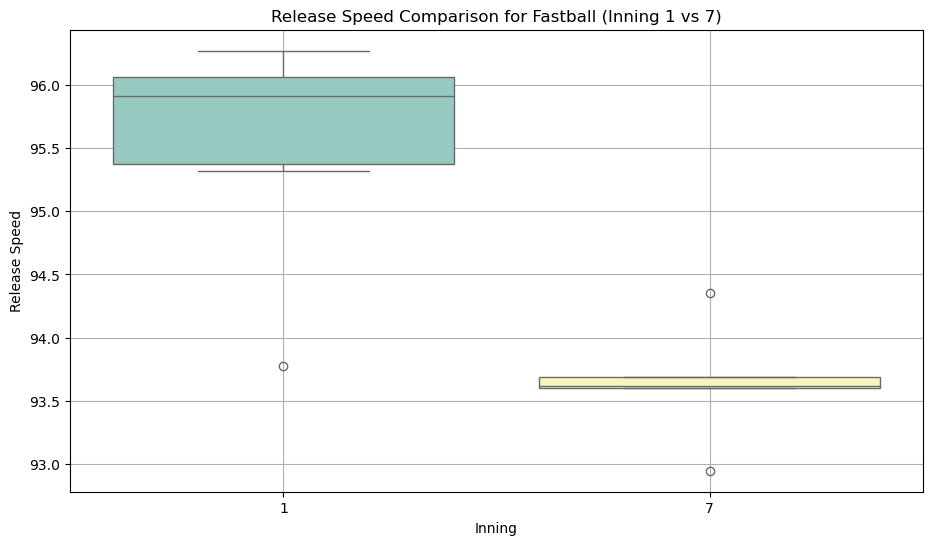

Saved: Fastball_RELEASE_SPEED_Inning_Comparison.png


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/423177621.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='INNING', y=metric, data=pitch_data, palette="Set3")


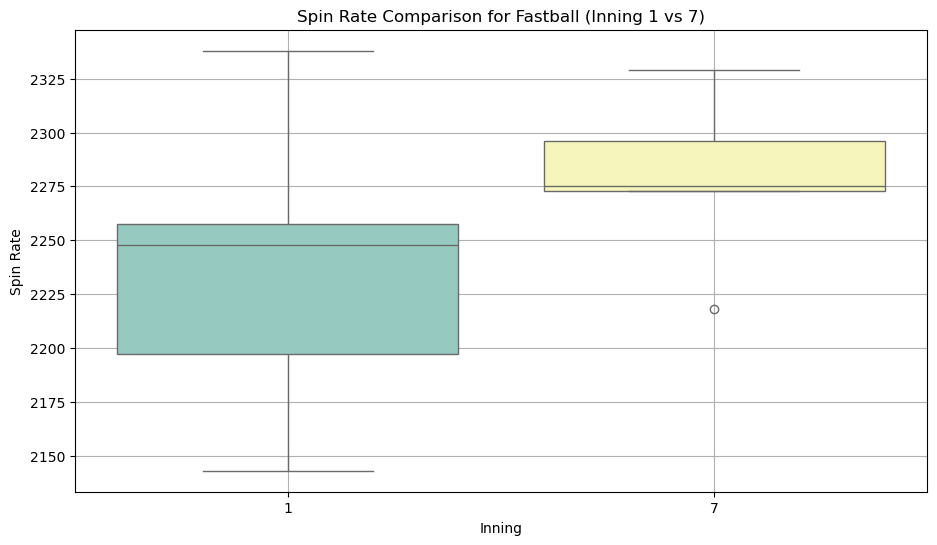

Saved: Fastball_SPIN_RATE_Inning_Comparison.png


'Pitch Comparison Statistics'

,Pitch Type,Metric,Inning 1 Mean,Inning 7 Mean,p-value,Effect Size
0,Curveball,RELEASE_SPEED,82.21968,80.97066,0.018522,2.076746
1,Curveball,SPIN_RATE,2935.18000,2999.78000,0.128762,-0.887521
2,Fastball,RELEASE_SPEED,95.44538,93.64210,0.025007,2.333500
3,Fastball,SPIN_RATE,2248.58000,2278.18000,0.325019,-0.519979


In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, sem

# Function to compute Cohen's d for effect size
def cohen_d(x, y):
    """Calculate Cohen's d for two samples."""
    n1, n2 = len(x), len(y)
    pooled_std = np.sqrt(((n1 - 1) * np.var(x, ddof=1) + (n2 - 1) * np.var(y, ddof=1)) / (n1 + n2 - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

# Exclude Changeups and Sinkers
excluded_pitches = ['Changeup', 'Sinker']
filtered_metrics_df = metrics_df[~metrics_df['PITCH_TYPE'].isin(excluded_pitches)]

# Select relevant columns and filter for only Inning 1 and 7
filtered_metrics_df = filtered_metrics_df[['INNING', 'PITCH_TYPE', 'RELEASE_SPEED', 'SPIN_RATE']]
filtered_metrics_df = filtered_metrics_df[filtered_metrics_df['INNING'].isin([1, 7])]

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Pitch Type', 'Metric', 'Inning 1 Mean', 'Inning 7 Mean', 'p-value', 'Effect Size'])

# Function to plot boxplots with p-values and effect sizes
def plot_with_stats(metric, data, pitch_type):
    """Creates box plots for a given metric with p-values and effect sizes annotated."""
    global results_df
    # Filter data for the given pitch type and metric
    pitch_data = data[data['PITCH_TYPE'] == pitch_type]

    # Calculate p-values and effect sizes
    first_inning = pitch_data[pitch_data['INNING'] == 1][metric].dropna()
    last_inning = pitch_data[pitch_data['INNING'] == 7][metric].dropna()

    # Match the lengths of both arrays by sampling the larger set to match the smaller set's size
    if len(first_inning) > len(last_inning):
        first_inning = first_inning.sample(n=len(last_inning), random_state=1)
    elif len(last_inning) > len(first_inning):
        last_inning = last_inning.sample(n=len(first_inning), random_state=1)

    # Perform paired t-test and compute Cohen's d only if there are enough samples
    if len(first_inning) > 1 and len(last_inning) > 1:  # Ensure enough data points for stats
        t_stat, p_val = ttest_rel(first_inning, last_inning)
        effect_size = cohen_d(first_inning, last_inning)
    else:
        p_val, effect_size = np.nan, np.nan

    # Calculate mean values for the table
    inning1_mean = first_inning.mean() if not first_inning.empty else np.nan
    inning7_mean = last_inning.mean() if not last_inning.empty else np.nan

    # Create a new DataFrame row and concatenate it with the results DataFrame
    new_row = pd.DataFrame({
        'Pitch Type': [pitch_type],
        'Metric': [metric],
        'Inning 1 Mean': [inning1_mean],
        'Inning 7 Mean': [inning7_mean],
        'p-value': [p_val],
        'Effect Size': [effect_size]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Create the boxplot
    plt.figure(figsize=(11, 6))
    sns.boxplot(x='INNING', y=metric, data=pitch_data, palette="Set3")

    # Customize the plot
    plt.title(f'{metric.replace("_", " ").title()} Comparison for {pitch_type} (Inning 1 vs 7)')
    plt.xlabel('Inning')
    plt.ylabel(metric.replace("_", " ").title())
    plt.grid(True)

    # Save the plot
    output_filename = f'{pitch_type}_{metric}_Inning_Comparison.png'
    plt.savefig(output_filename)
    plt.show()
    print(f"Saved: {output_filename}")

# Loop through each unique pitch type and create separate plots for RELEASE_SPEED and SPIN_RATE
for pitch_type in filtered_metrics_df['PITCH_TYPE'].unique():
    print(f"Generating plots for {pitch_type}...")
    for metric in ['RELEASE_SPEED', 'SPIN_RATE']:
        plot_with_stats(metric, filtered_metrics_df, pitch_type)

# Display the final results table
display("Pitch Comparison Statistics", results_df)


QUESTION 4

/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/2832373826.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_values = filtered_data.groupby(['INNING', 'PITCH_TYPE', 'PITCHER_PITCH_COUNT']).apply(


'Filtered and Combined Peak Time Difference Table'

,INNING,PITCH_TYPE,Peak_Pelvis_Velocity,Peak_Trunk_Velocity,Time_Difference (ms)
0,1,Curveball,770.07 ± 24.77,1118.79 ± 12.12,29.15 ± 3.60
1,1,Fastball,782.23 ± 15.73,1144.13 ± 17.76,26.28 ± 6.02
2,7,Curveball,800.65 ± 14.42,1111.42 ± 16.11,30.42 ± 3.86
3,7,Fastball,797.16 ± 19.23,1120.39 ± 21.75,33.07 ± 6.16


Table saved to: /Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 4/peak_time_diff_table_combined.xlsx


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_95370/2832373826.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='INNING', y='Time_Difference_Pelvis_to_Trunk', data=filtered_time_diff, palette="Set3")


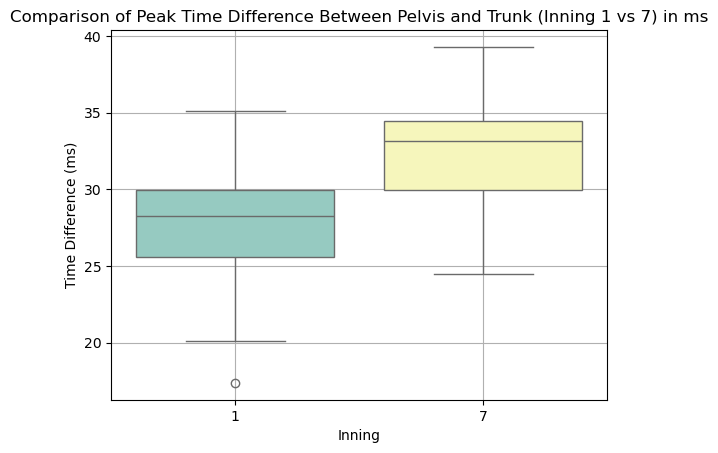

Boxplot saved to: /Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 4/peak_time_difference_plot_combined.png


In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Step 1: Compute Peak Time Differences and Angular Velocity Means
def compute_peak_time_and_velo_differences(signals_data):
    """Calculate peak angular velocity and time difference between peak pelvis and peak trunk angular velocities."""
    # Exclude Sinkers and Changeups
    filtered_data = signals_data[~signals_data['PITCH_TYPE'].isin(['Sinker', 'Changeup'])]

    # Group by Inning, Pitch Type, and Pitch Count to identify peaks and times for each pitch
    peak_values = filtered_data.groupby(['INNING', 'PITCH_TYPE', 'PITCHER_PITCH_COUNT']).apply(
        lambda group: pd.Series({
            'Peak_Pelvis_Velocity': group['Pelvis_Rotational_Velocity'].abs().max(),
            'Peak_Trunk_Velocity': group['Trunk_Rotational_Velocity'].abs().max(),
            'Pelvis_Peak_Time': group.loc[group['Pelvis_Rotational_Velocity'].idxmax(), 'ZERO_TIME'] if not group['Pelvis_Rotational_Velocity'].empty else np.nan,
            'Trunk_Peak_Time': group.loc[group['Trunk_Rotational_Velocity'].idxmax(), 'ZERO_TIME'] if not group['Trunk_Rotational_Velocity'].empty else np.nan,
        })
    ).reset_index()
    
    # Calculate the time difference between Pelvis and Trunk peaks in milliseconds
    peak_values['Time_Difference_Pelvis_to_Trunk'] = (peak_values['Trunk_Peak_Time'] - peak_values['Pelvis_Peak_Time']) * 1000  # Convert to milliseconds
    
    # Filter unrealistic peak values based on thresholds
    peak_values = peak_values[
        (peak_values['Peak_Pelvis_Velocity'].between(200, 5000)) &  # Filter pelvic rotational velocities
        (peak_values['Peak_Trunk_Velocity'].between(300, 6000)) &   # Filter trunk rotational velocities
        (peak_values['Time_Difference_Pelvis_to_Trunk'].abs() < 100)  # Time differences below 100 ms
    ]
    
    # Apply Z-score filtering to further remove outliers
    peak_values = peak_values[(np.abs(zscore(peak_values[['Peak_Pelvis_Velocity', 'Peak_Trunk_Velocity']])) < 3).all(axis=1)]
    
    return peak_values

# Step 2: Create the Peak Time Difference Table
peak_time_diff_table = compute_peak_time_and_velo_differences(signals_data)

# Step 3: Calculate the Mean and Standard Deviation of Angular Velocities and Time Differences by Inning and Pitch Type
mean_time_diff_stats = peak_time_diff_table.groupby(['INNING', 'PITCH_TYPE']).agg({
    'Peak_Pelvis_Velocity': ['mean', 'std'],
    'Peak_Trunk_Velocity': ['mean', 'std'],
    'Time_Difference_Pelvis_to_Trunk': ['mean', 'std']
}).reset_index()

# Flatten columns
mean_time_diff_stats.columns = [
    'INNING', 'PITCH_TYPE',
    'Peak_Pelvis_Velocity_Mean', 'Peak_Pelvis_Velocity_Std',
    'Peak_Trunk_Velocity_Mean', 'Peak_Trunk_Velocity_Std',
    'Time_Difference_Mean (ms)', 'Time_Difference_Std (ms)'
]

# Combine Mean and Std columns into single columns with 'Mean ± Std'
def combine_mean_std(mean_col, std_col):
    """Format the Mean ± Std with two decimal places."""
    return mean_time_diff_stats[mean_col].map(lambda x: f"{x:.2f}") + " ± " + mean_time_diff_stats[std_col].map(lambda x: f"{x:.2f}")

# Apply the combination for each metric
mean_time_diff_stats['Peak_Pelvis_Velocity'] = combine_mean_std('Peak_Pelvis_Velocity_Mean', 'Peak_Pelvis_Velocity_Std')
mean_time_diff_stats['Peak_Trunk_Velocity'] = combine_mean_std('Peak_Trunk_Velocity_Mean', 'Peak_Trunk_Velocity_Std')
mean_time_diff_stats['Time_Difference (ms)'] = combine_mean_std('Time_Difference_Mean (ms)', 'Time_Difference_Std (ms)')

# Select only the relevant columns
final_table = mean_time_diff_stats[['INNING', 'PITCH_TYPE', 'Peak_Pelvis_Velocity', 'Peak_Trunk_Velocity', 'Time_Difference (ms)']]

# Display the table
display("Filtered and Combined Peak Time Difference Table", final_table)

# Save the new table to an Excel file
output_file_path = "/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 4/peak_time_diff_table_combined.xlsx"
final_table.to_excel(output_file_path, index=False)
print(f"Table saved to: {output_file_path}")

# Step 4: Generate a Boxplot for Time Difference Between Inning 1 and Inning 7
# Filter for only Inning 1 and Inning 7
filtered_time_diff = peak_time_diff_table[peak_time_diff_table['INNING'].isin([1, 7])]

# Create the boxplot for Time Difference in milliseconds
plt.figure()
sns.boxplot(x='INNING', y='Time_Difference_Pelvis_to_Trunk', data=filtered_time_diff, palette="Set3")

# Customize the plot
plt.title('Comparison of Peak Time Difference Between Pelvis and Trunk (Inning 1 vs 7) in ms')
plt.xlabel('Inning')
plt.ylabel('Time Difference (ms)')
plt.grid(True)

# Save the plot
output_plot_path = "/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 4/peak_time_difference_plot_combined.png"
plt.savefig(output_plot_path)
plt.show()

print(f"Boxplot saved to: {output_plot_path}")




COM PLOTS

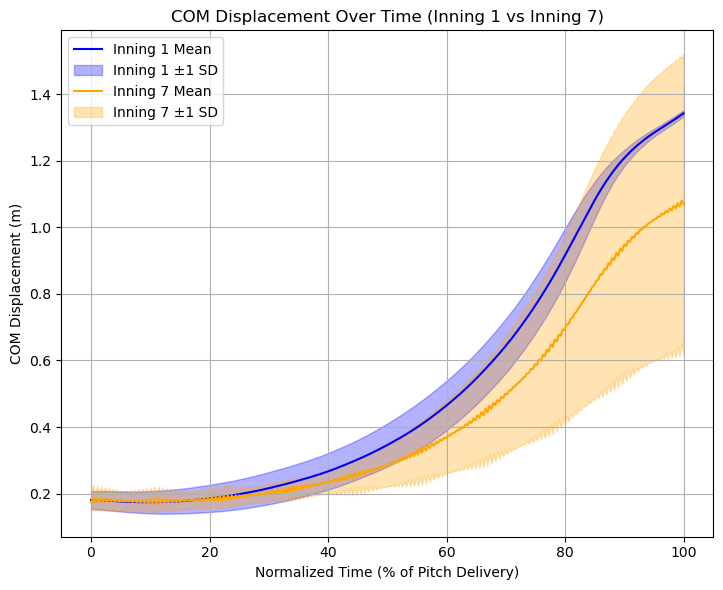

In [263]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def filter_and_plot_COM_displacement(data, plot_title="COM Displacement Over Time"):
    """Generate mean COM displacement plots with SD shading after filtering and trimming."""
    
    # Step 1: Filter and trim each pitch's data, then compute velocity
    all_pitch_data = []
    
    # Assuming pitch counts and innings are defined in the dataframe
    for inning in [1, 7]:
        inning_pitches = data[data['INNING'] == inning]
        
        for pitch_count in inning_pitches['PITCHER_PITCH_COUNT'].unique():
            # Filter out each individual pitch
            single_pitch_data = inning_pitches[inning_pitches['PITCHER_PITCH_COUNT'] == pitch_count]

            # Trim first and last 5 frames
            trimmed_data = single_pitch_data.iloc[5:-5]

            # Extract necessary columns
            t0 = trimmed_data['ZERO_TIME'].values
            com_displacement = trimmed_data['MODEL_COG_LAB_Y'].values

            # Normalize time to 300 points for uniformity
            normalized_time = np.linspace(0, 100, 300)
            com_displacement = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(com_displacement)), com_displacement)

            # Store the results
            all_pitch_data.append((inning, com_displacement, normalized_time))
    
    # Step 2: Aggregate data for mean and standard deviation
    mean_std_dict = {}
    for inning in [1, 7]:
        # Collect data for the given inning
        inning_data = [pitch[1] for pitch in all_pitch_data if pitch[0] == inning]
        inning_data = np.array(inning_data)

        # Compute mean and standard deviation
        mean_values = np.mean(inning_data, axis=0)
        std_values = np.std(inning_data, axis=0)
        mean_std_dict[inning] = (mean_values, std_values)
    
    # Step 3: Generate the plots
    plt.figure(figsize=(14, 6))
    
    # Extract the normalized time vector
    normalized_time = all_pitch_data[0][2]  # Use time from any pitch since they are standardized
    
    # Plot 1: Mean COM Displacement with SD shading
    plt.subplot(1, 2, 1)
    for inning, color in zip([1, 7], ['blue', 'orange']):
        mean_values, std_values = mean_std_dict[inning]
        plt.plot(normalized_time, mean_values, color=color, label=f'Inning {inning} Mean')
        plt.fill_between(normalized_time, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3, label=f'Inning {inning} ±1 SD')

    plt.title(f'{plot_title} (Inning 1 vs Inning 7)')
    plt.xlabel('Normalized Time (% of Pitch Delivery)')
    plt.ylabel('COM Displacement (m)')
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage with the `signals_df` dataframe
filter_and_plot_COM_displacement(signals_df)


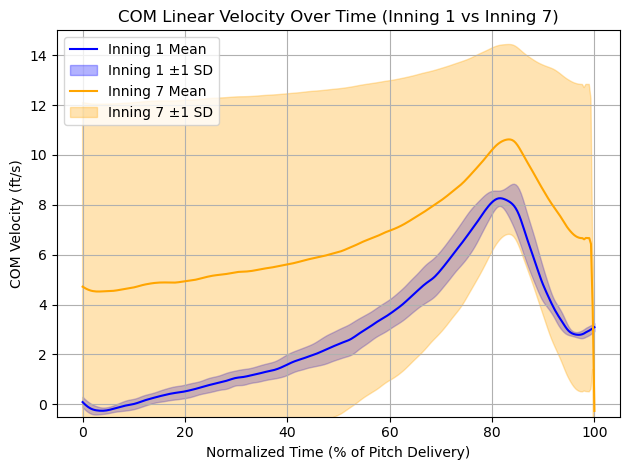

In [276]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

# Custom smoothing and threshold filtering function
def smooth_and_filter(signal, max_value=5):
    # Apply Savitzky-Golay filter for smoothing (window length 11, polynomial order 2)
    smoothed_signal = savgol_filter(signal, window_length=11, polyorder=2)

    # Apply threshold filtering to ensure values don't exceed the max_value (e.g., 5 m/s)
    filtered_signal = np.clip(smoothed_signal, a_min=None, a_max=max_value)
    return filtered_signal

def plot_com_linear_velocity_filtered_ft_per_s(data, plot_title="COM Linear Velocity Over Time"):
    """Generate mean COM linear velocity plots with SD shading after filtering, converting to ft/s, and trimming."""
    
    # Step 1: Convert velocity from m/s to ft/s
    conversion_factor = 3.28084  # 1 m/s = 3.28084 ft/s

    # Step 2: Filter and trim each pitch's data, then compute velocity in ft/s
    all_pitch_data = []
    
    # Assuming pitch counts and innings are defined in the dataframe
    for inning in [1, 7]:
        inning_pitches = data[data['INNING'] == inning]
        
        for pitch_count in inning_pitches['PITCHER_PITCH_COUNT'].unique():
            # Filter out each individual pitch
            single_pitch_data = inning_pitches[inning_pitches['PITCHER_PITCH_COUNT'] == pitch_count]

            # Trim first and last 5 frames
            trimmed_data = single_pitch_data.iloc[5:-5]

            # Extract necessary columns
            t0 = trimmed_data['ZERO_TIME'].values
            com_velocity = trimmed_data['COM_Linear_Velocity'].values

            # Normalize time to 300 points for uniformity
            normalized_time = np.linspace(0, 100, 300)
            com_velocity = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(com_velocity)), com_velocity)

            # Apply smoothing and filtering, then convert to ft/s
            com_velocity_filtered = smooth_and_filter(com_velocity) * conversion_factor

            # Store the results
            all_pitch_data.append((inning, com_velocity_filtered, normalized_time))
    
    # Step 3: Aggregate data for mean and standard deviation in ft/s
    mean_std_dict = {}
    for inning in [1, 7]:
        # Collect data for the given inning
        inning_data = [pitch[1] for pitch in all_pitch_data if pitch[0] == inning]
        inning_data = np.array(inning_data)

        # Compute mean and standard deviation
        mean_values = np.mean(inning_data, axis=0)
        std_values = np.std(inning_data, axis=0)
        mean_std_dict[inning] = (mean_values, std_values)
    
    # Step 4: Generate the plot for linear velocity in ft/s
    plt.figure()
    
    # Extract the normalized time vector
    normalized_time = all_pitch_data[0][2]  # Use time from any pitch since they are standardized
    
    # Plot: Mean COM Linear Velocity with SD shading in ft/s
    for inning, color in zip([1, 7], ['blue', 'orange']):
        mean_values, std_values = mean_std_dict[inning]
        plt.plot(normalized_time, mean_values, color=color, label=f'Inning {inning} Mean')
        plt.fill_between(normalized_time, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3, label=f'Inning {inning} ±1 SD')

    plt.title(f'{plot_title} (Inning 1 vs Inning 7)')
    plt.xlabel('Normalized Time (% of Pitch Delivery)')
    plt.ylabel('COM Velocity (ft/s)')
    plt.ylim(-0.5, 15)  # Adjust y-axis limits for ft/s
    plt.legend(loc = 'upper left')
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage with the `signals_df` dataframe, assuming COM velocity is already computed in 'COM_Linear_Velocity'
plot_com_linear_velocity_filtered_ft_per_s(signals_df)


In [267]:
# TEST:    plt.plot(signals_df['ZERO_TIME'][0:300],signals_df['MODEL_COG_LAB_Y'][0:300])

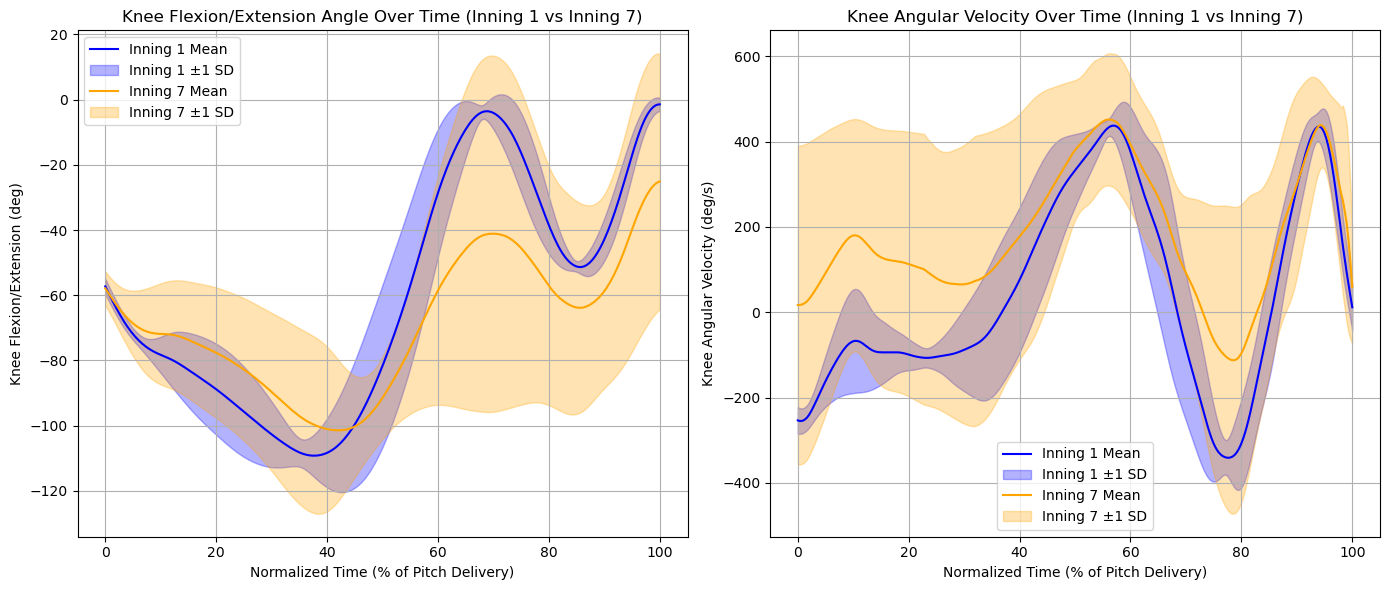

In [297]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Helper Function: Smoothing and Clipping
def smooth_and_clip(signal, clip_value=150):
    """Smooth the signal using Savitzky-Golay filter and clip at a specified value."""
    smoothed_signal = savgol_filter(signal, window_length=11, polyorder=2)
    clipped_signal = np.clip(smoothed_signal, a_min=-clip_value, a_max=clip_value)
    return clipped_signal

# Function to Calculate Knee Angular Velocity
def compute_angular_velocity(angle_data, time_data):
    """Compute the angular velocity of the knee flexion/extension."""
    angular_velocity = np.gradient(angle_data, time_data)
    return angular_velocity

def plot_knee_flexion_and_velocity(data, plot_title="Knee Flexion/Extension and Velocity Over Time"):
    """Generate mean plots for knee flexion/extension and its velocity with SD shading for Inning 1 vs Inning 7."""
    
    # Step 1: Extract and prepare data for analysis
    all_pitch_data_angles = []
    all_pitch_data_velocities = []

    for inning in [1, 7]:
        inning_pitches = data[data['INNING'] == inning]
        
        for pitch_count in inning_pitches['PITCHER_PITCH_COUNT'].unique():
            # Filter out each individual pitch and trim first and last 5 frames
            single_pitch_data = inning_pitches[inning_pitches['PITCHER_PITCH_COUNT'] == pitch_count].iloc[5:-5]

            # Extract necessary columns
            t0 = single_pitch_data['ZERO_TIME'].values
            knee_angle = single_pitch_data['FRONTKNEE_X'].values

            # Calculate the angular velocity of knee flexion/extension
            knee_velocity = compute_angular_velocity(knee_angle, t0)

            # Normalize time to 300 points for uniformity
            normalized_time = np.linspace(0, 100, 300)
            knee_angle = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(knee_angle)), knee_angle)
            knee_velocity = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(knee_velocity)), knee_velocity)

            # Apply smoothing and clipping
            knee_angle_filtered = smooth_and_clip(knee_angle, clip_value=150)
            knee_velocity_filtered = smooth_and_clip(knee_velocity, clip_value=600)  # Assume 600 deg/s as max value

            # Store the results
            all_pitch_data_angles.append((inning, knee_angle_filtered, normalized_time))
            all_pitch_data_velocities.append((inning, knee_velocity_filtered, normalized_time))
    
    # Step 2: Aggregate data for mean and standard deviation
    mean_std_dict_angle = {}
    mean_std_dict_velocity = {}

    for inning in [1, 7]:
        # Collect data for the given inning
        inning_data_angle = [pitch[1] for pitch in all_pitch_data_angles if pitch[0] == inning]
        inning_data_velocity = [pitch[1] for pitch in all_pitch_data_velocities if pitch[0] == inning]
        
        inning_data_angle = np.array(inning_data_angle)
        inning_data_velocity = np.array(inning_data_velocity)

        # Compute mean and standard deviation
        mean_values_angle = np.mean(inning_data_angle, axis=0)
        std_values_angle = np.std(inning_data_angle, axis=0)
        mean_values_velocity = np.mean(inning_data_velocity, axis=0)
        std_values_velocity = np.std(inning_data_velocity, axis=0)
        
        mean_std_dict_angle[inning] = (mean_values_angle, std_values_angle)
        mean_std_dict_velocity[inning] = (mean_values_velocity, std_values_velocity)
    
    # Step 3: Generate the plots
    plt.figure(figsize=(14, 6))

    # Extract the normalized time vector
    normalized_time = all_pitch_data_angles[0][2]  # Use time from any pitch since they are standardized
    
    # Plot 1: Knee Flexion/Extension Angle with SD shading
    plt.subplot(1, 2, 1)
    for inning, color in zip([1, 7], ['blue', 'orange']):
        mean_values, std_values = mean_std_dict_angle[inning]
        plt.plot(normalized_time, mean_values, color=color, label=f'Inning {inning} Mean')
        plt.fill_between(normalized_time, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3, label=f'Inning {inning} ±1 SD')

    plt.title('Knee Flexion/Extension Angle Over Time (Inning 1 vs Inning 7)')
    plt.xlabel('Normalized Time (% of Pitch Delivery)')
    plt.ylabel('Knee Flexion/Extension (deg)')
    plt.legend()
    plt.grid(True)

    # Plot 2: Knee Angular Velocity with SD shading
    plt.subplot(1, 2, 2)
    for inning, color in zip([1, 7], ['blue', 'orange']):
        mean_values, std_values = mean_std_dict_velocity[inning]
        plt.plot(normalized_time, mean_values, color=color, label=f'Inning {inning} Mean')
        plt.fill_between(normalized_time, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3, label=f'Inning {inning} ±1 SD')

    plt.title('Knee Angular Velocity Over Time (Inning 1 vs Inning 7)')
    plt.xlabel('Normalized Time (% of Pitch Delivery)')
    plt.ylabel('Knee Angular Velocity (deg/s)')
    plt.legend()
    plt.grid(True)

    # Display the plots
    plt.tight_layout()
    plt.show()

# Example usage with the `signals_df` dataframe
plot_knee_flexion_and_velocity(signals_df)


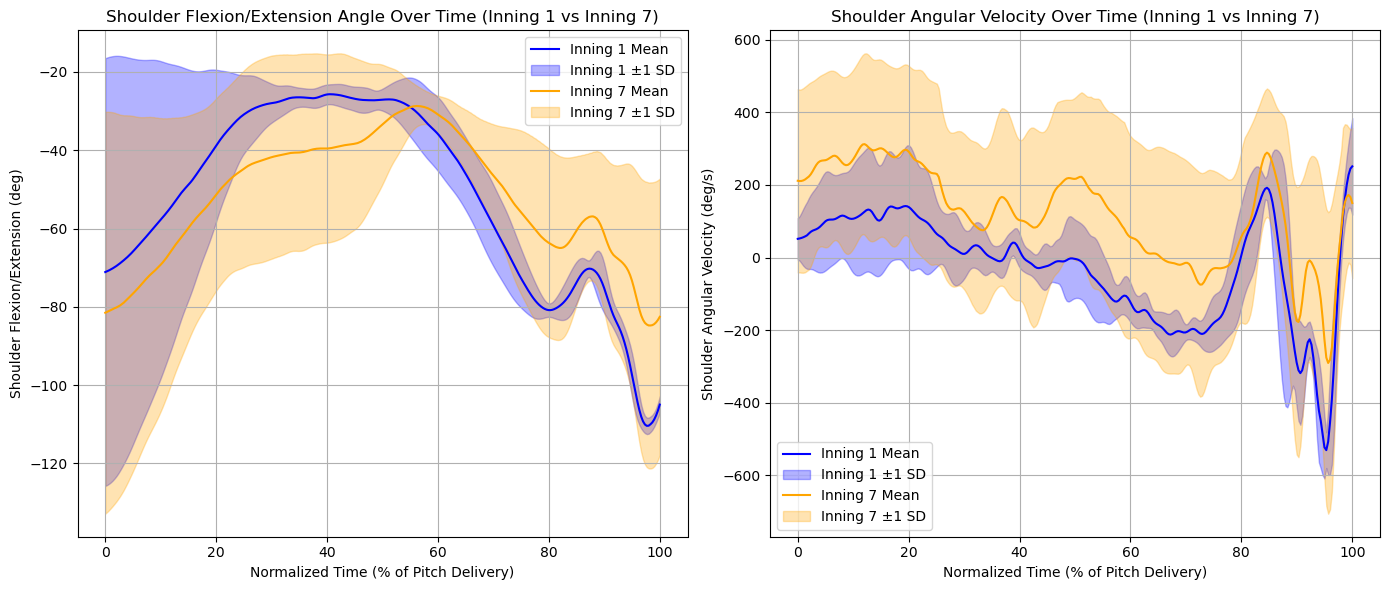

In [298]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Function to Calculate Angular Velocity
def compute_angular_velocity(angle_data, time_data):
    """Compute the angular velocity using the angle data and time data."""
    angular_velocity = np.gradient(angle_data, time_data)
    return angular_velocity

# Helper Function: Smoothing and Clipping
def smooth_and_clip(signal, clip_value=150):
    """Smooth the signal using Savitzky-Golay filter and clip at a specified value."""
    smoothed_signal = savgol_filter(signal, window_length=11, polyorder=2)
    clipped_signal = np.clip(smoothed_signal, a_min=-clip_value, a_max=clip_value)
    return clipped_signal

# Function to Generate Plots for Shoulder Flexion/Extension and Angular Velocity
def plot_shoulder_flexion_and_velocity(data, plot_title="Shoulder Flexion/Extension and Velocity Over Time"):
    """Generate mean plots for shoulder flexion/extension and its velocity with SD shading for Inning 1 vs Inning 7."""
    
    # Step 1: Extract and prepare data for analysis
    all_pitch_data_angles = []
    all_pitch_data_velocities = []

    for inning in [1, 7]:
        inning_pitches = data[data['INNING'] == inning]
        
        for pitch_count in inning_pitches['PITCHER_PITCH_COUNT'].unique():
            # Filter out each individual pitch and trim first and last 5 frames
            single_pitch_data = inning_pitches[inning_pitches['PITCHER_PITCH_COUNT'] == pitch_count].iloc[5:-5]

            # Extract necessary columns
            t0 = single_pitch_data['ZERO_TIME'].values
            shoulder_angle = single_pitch_data['SHOULDER_Y'].values

            # Calculate the angular velocity of shoulder flexion/extension
            shoulder_velocity = compute_angular_velocity(shoulder_angle, t0)

            # Normalize time to 300 points for uniformity
            normalized_time = np.linspace(0, 100, 300)
            shoulder_angle = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(shoulder_angle)), shoulder_angle)
            shoulder_velocity = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(shoulder_velocity)), shoulder_velocity)

            # Apply smoothing and clipping
            shoulder_angle_filtered = smooth_and_clip(shoulder_angle, clip_value=150)
            shoulder_velocity_filtered = smooth_and_clip(shoulder_velocity, clip_value=600)  # Assume 600 deg/s as max value

            # Store the results
            all_pitch_data_angles.append((inning, shoulder_angle_filtered, normalized_time))
            all_pitch_data_velocities.append((inning, shoulder_velocity_filtered, normalized_time))
    
    # Step 2: Aggregate data for mean and standard deviation
    mean_std_dict_angle = {}
    mean_std_dict_velocity = {}

    for inning in [1, 7]:
        # Collect data for the given inning
        inning_data_angle = [pitch[1] for pitch in all_pitch_data_angles if pitch[0] == inning]
        inning_data_velocity = [pitch[1] for pitch in all_pitch_data_velocities if pitch[0] == inning]
        
        inning_data_angle = np.array(inning_data_angle)
        inning_data_velocity = np.array(inning_data_velocity)

        # Compute mean and standard deviation
        mean_values_angle = np.mean(inning_data_angle, axis=0)
        std_values_angle = np.std(inning_data_angle, axis=0)
        mean_values_velocity = np.mean(inning_data_velocity, axis=0)
        std_values_velocity = np.std(inning_data_velocity, axis=0)
        
        mean_std_dict_angle[inning] = (mean_values_angle, std_values_angle)
        mean_std_dict_velocity[inning] = (mean_values_velocity, std_values_velocity)
    
    # Step 3: Generate the plots
    plt.figure(figsize=(14, 6))

    # Extract the normalized time vector
    normalized_time = all_pitch_data_angles[0][2]  # Use time from any pitch since they are standardized
    
    # Plot 1: Shoulder Flexion/Extension Angle with SD shading
    plt.subplot(1, 2, 1)
    for inning, color in zip([1, 7], ['blue', 'orange']):
        mean_values, std_values = mean_std_dict_angle[inning]
        plt.plot(normalized_time, mean_values, color=color, label=f'Inning {inning} Mean')
        plt.fill_between(normalized_time, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3, label=f'Inning {inning} ±1 SD')

    plt.title('Shoulder Flexion/Extension Angle Over Time (Inning 1 vs Inning 7)')
    plt.xlabel('Normalized Time (% of Pitch Delivery)')
    plt.ylabel('Shoulder Flexion/Extension (deg)')
    plt.legend()
    plt.grid(True)

    # Plot 2: Shoulder Angular Velocity with SD shading
    plt.subplot(1, 2, 2)
    for inning, color in zip([1, 7], ['blue', 'orange']):
        mean_values, std_values = mean_std_dict_velocity[inning]
        plt.plot(normalized_time, mean_values, color=color, label=f'Inning {inning} Mean')
        plt.fill_between(normalized_time, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3, label=f'Inning {inning} ±1 SD')

    plt.title('Shoulder Angular Velocity Over Time (Inning 1 vs Inning 7)')
    plt.xlabel('Normalized Time (% of Pitch Delivery)')
    plt.ylabel('Shoulder Angular Velocity (deg/s)')
    plt.legend()
    plt.grid(True)

    # Display the plots
    plt.tight_layout()
    plt.show()

# Example usage with the `signals_df` dataframe
plot_shoulder_flexion_and_velocity(signals_df)


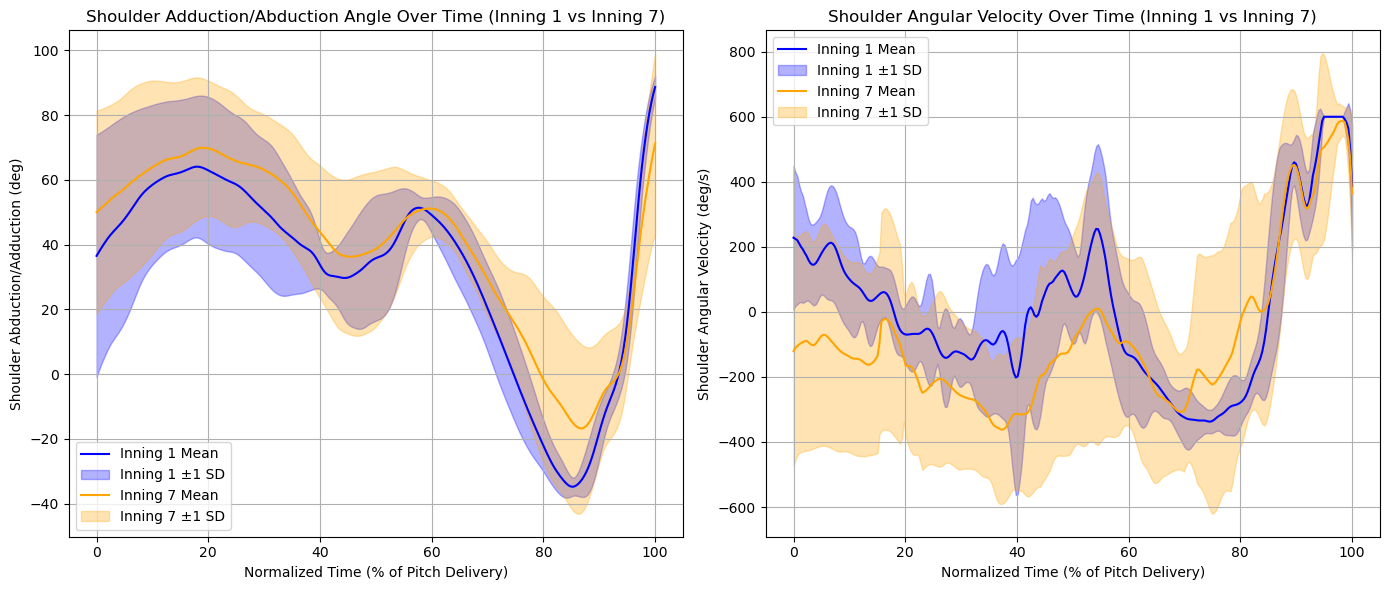

In [301]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Function to Calculate Angular Velocity
def compute_angular_velocity(angle_data, time_data):
    """Compute the angular velocity using the angle data and time data."""
    angular_velocity = np.gradient(angle_data, time_data)
    return angular_velocity

# Helper Function: Smoothing and Clipping
def smooth_and_clip(signal, clip_value=150):
    """Smooth the signal using Savitzky-Golay filter and clip at a specified value."""
    smoothed_signal = savgol_filter(signal, window_length=15, polyorder=2)
    clipped_signal = np.clip(smoothed_signal, a_min=-clip_value, a_max=clip_value)
    return clipped_signal

# Function to Generate Plots for Shoulder Abduction/Adduction and Angular Velocity
def plot_shoulder_abduction_and_velocity(data, plot_title="Shoulder Abduction/Adduction and Velocity Over Time"):
    """Generate mean plots for shoulder abduction/adduction and its velocity with SD shading for Inning 1 vs Inning 7."""
    
    # Step 1: Extract and prepare data for analysis
    all_pitch_data_angles = []
    all_pitch_data_velocities = []

    for inning in [1, 7]:
        inning_pitches = data[data['INNING'] == inning]
        
        for pitch_count in inning_pitches['PITCHER_PITCH_COUNT'].unique():
            # Filter out each individual pitch and trim first and last 5 frames
            single_pitch_data = inning_pitches[inning_pitches['PITCHER_PITCH_COUNT'] == pitch_count].iloc[5:-5]

            # Extract necessary columns
            t0 = single_pitch_data['ZERO_TIME'].values
            shoulder_angle = single_pitch_data['SHOULDER_X'].values

            # Calculate the angular velocity of shoulder abduction/adduction
            shoulder_velocity = compute_angular_velocity(shoulder_angle, t0)

            # Normalize time to 300 points for uniformity
            normalized_time = np.linspace(0, 100, 300)
            shoulder_angle = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(shoulder_angle)), shoulder_angle)
            shoulder_velocity = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(shoulder_velocity)), shoulder_velocity)

            # Apply smoothing and clipping
            shoulder_angle_filtered = smooth_and_clip(shoulder_angle, clip_value=150)
            shoulder_velocity_filtered = smooth_and_clip(shoulder_velocity, clip_value=600)  # Assume 600 deg/s as max value

            # Store the results
            all_pitch_data_angles.append((inning, shoulder_angle_filtered, normalized_time))
            all_pitch_data_velocities.append((inning, shoulder_velocity_filtered, normalized_time))
    
    # Step 2: Aggregate data for mean and standard deviation
    mean_std_dict_angle = {}
    mean_std_dict_velocity = {}

    for inning in [1, 7]:
        # Collect data for the given inning
        inning_data_angle = [pitch[1] for pitch in all_pitch_data_angles if pitch[0] == inning]
        inning_data_velocity = [pitch[1] for pitch in all_pitch_data_velocities if pitch[0] == inning]
        
        inning_data_angle = np.array(inning_data_angle)
        inning_data_velocity = np.array(inning_data_velocity)

        # Compute mean and standard deviation
        mean_values_angle = np.mean(inning_data_angle, axis=0)
        std_values_angle = np.std(inning_data_angle, axis=0)
        mean_values_velocity = np.mean(inning_data_velocity, axis=0)
        std_values_velocity = np.std(inning_data_velocity, axis=0)
        
        mean_std_dict_angle[inning] = (mean_values_angle, std_values_angle)
        mean_std_dict_velocity[inning] = (mean_values_velocity, std_values_velocity)
    
    # Step 3: Generate the plots
    plt.figure(figsize=(14, 6))

    # Extract the normalized time vector
    normalized_time = all_pitch_data_angles[0][2]  # Use time from any pitch since they are standardized
    
    # Plot 1: Shoulder Abduction/Adduction Angle with SD shading
    plt.subplot(1, 2, 1)
    for inning, color in zip([1, 7], ['blue', 'orange']):
        mean_values, std_values = mean_std_dict_angle[inning]
        plt.plot(normalized_time, mean_values, color=color, label=f'Inning {inning} Mean')
        plt.fill_between(normalized_time, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3, label=f'Inning {inning} ±1 SD')

    plt.title('Shoulder Adduction/Abduction Angle Over Time (Inning 1 vs Inning 7)')
    plt.xlabel('Normalized Time (% of Pitch Delivery)')
    plt.ylabel('Shoulder Abduction/Adduction (deg)')
    plt.legend()
    plt.grid(True)

    # Plot 2: Shoulder Angular Velocity with SD shading
    plt.subplot(1, 2, 2)
    for inning, color in zip([1, 7], ['blue', 'orange']):
        mean_values, std_values = mean_std_dict_velocity[inning]
        plt.plot(normalized_time, mean_values, color=color, label=f'Inning {inning} Mean')
        plt.fill_between(normalized_time, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3, label=f'Inning {inning} ±1 SD')

    plt.title('Shoulder Angular Velocity Over Time (Inning 1 vs Inning 7)')
    plt.xlabel('Normalized Time (% of Pitch Delivery)')
    plt.ylabel('Shoulder Angular Velocity (deg/s)')
    plt.legend()
    plt.grid(True)

    # Display the plots
    plt.tight_layout()
    plt.show()

# Example usage with the `signals_df` dataframe
plot_shoulder_abduction_and_velocity(signals_df)


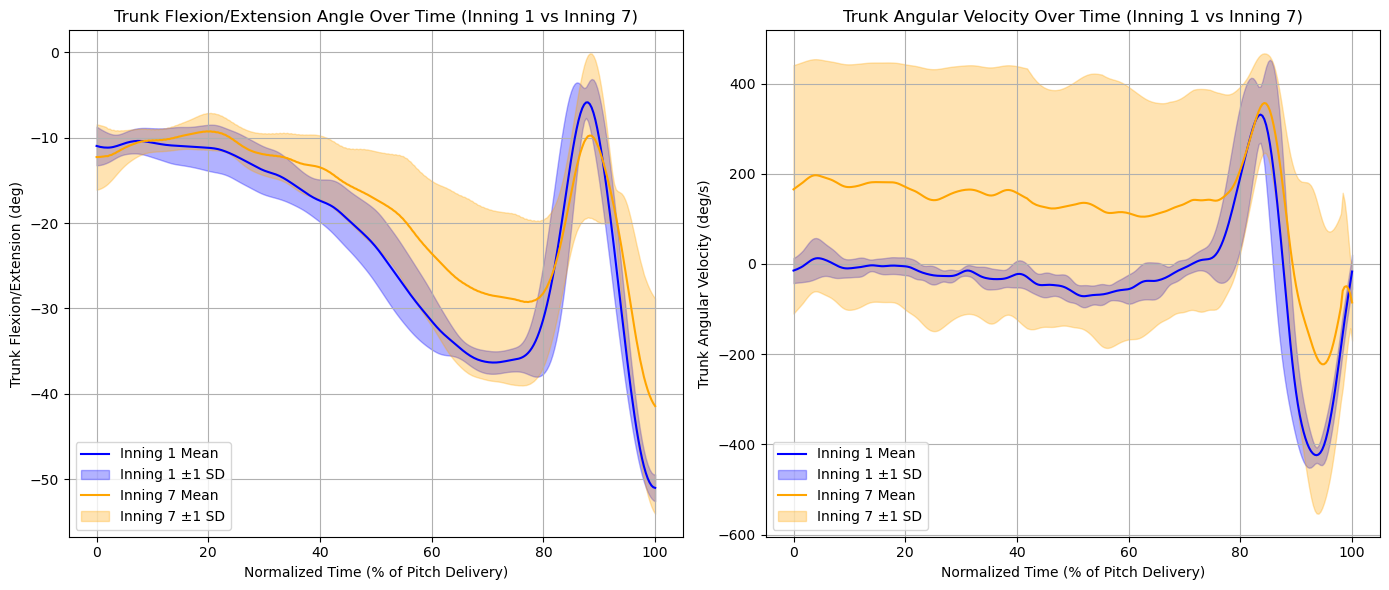

In [302]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Function to Calculate Angular Velocity
def compute_angular_velocity(angle_data, time_data):
    """Compute the angular velocity using the angle data and time data."""
    angular_velocity = np.gradient(angle_data, time_data)
    return angular_velocity

# Helper Function: Smoothing and Clipping
def smooth_and_clip(signal, clip_value=150):
    """Smooth the signal using Savitzky-Golay filter and clip at a specified value."""
    smoothed_signal = savgol_filter(signal, window_length=11, polyorder=2)
    clipped_signal = np.clip(smoothed_signal, a_min=-clip_value, a_max=clip_value)
    return clipped_signal

# Function to Generate Plots for Trunk Flexion/Extension and Angular Velocity
def plot_trunk_flexion_and_velocity(data, plot_title="Trunk Flexion/Extension and Velocity Over Time"):
    """Generate mean plots for trunk flexion/extension and its velocity with SD shading for Inning 1 vs Inning 7."""
    
    # Step 1: Extract and prepare data for analysis
    all_pitch_data_angles = []
    all_pitch_data_velocities = []

    for inning in [1, 7]:
        inning_pitches = data[data['INNING'] == inning]
        
        for pitch_count in inning_pitches['PITCHER_PITCH_COUNT'].unique():
            # Filter out each individual pitch and trim first and last 5 frames
            single_pitch_data = inning_pitches[inning_pitches['PITCHER_PITCH_COUNT'] == pitch_count].iloc[5:-5]

            # Extract necessary columns
            t0 = single_pitch_data['ZERO_TIME'].values
            trunk_angle = single_pitch_data['TRUNK_X'].values

            # Calculate the angular velocity of trunk flexion/extension
            trunk_velocity = compute_angular_velocity(trunk_angle, t0)

            # Normalize time to 300 points for uniformity
            normalized_time = np.linspace(0, 100, 300)
            trunk_angle = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(trunk_angle)), trunk_angle)
            trunk_velocity = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(trunk_velocity)), trunk_velocity)

            # Apply smoothing and clipping
            trunk_angle_filtered = smooth_and_clip(trunk_angle, clip_value=150)
            trunk_velocity_filtered = smooth_and_clip(trunk_velocity, clip_value=600)  # Assume 600 deg/s as max value

            # Store the results
            all_pitch_data_angles.append((inning, trunk_angle_filtered, normalized_time))
            all_pitch_data_velocities.append((inning, trunk_velocity_filtered, normalized_time))
    
    # Step 2: Aggregate data for mean and standard deviation
    mean_std_dict_angle = {}
    mean_std_dict_velocity = {}

    for inning in [1, 7]:
        # Collect data for the given inning
        inning_data_angle = [pitch[1] for pitch in all_pitch_data_angles if pitch[0] == inning]
        inning_data_velocity = [pitch[1] for pitch in all_pitch_data_velocities if pitch[0] == inning]
        
        inning_data_angle = np.array(inning_data_angle)
        inning_data_velocity = np.array(inning_data_velocity)

        # Compute mean and standard deviation
        mean_values_angle = np.mean(inning_data_angle, axis=0)
        std_values_angle = np.std(inning_data_angle, axis=0)
        mean_values_velocity = np.mean(inning_data_velocity, axis=0)
        std_values_velocity = np.std(inning_data_velocity, axis=0)
        
        mean_std_dict_angle[inning] = (mean_values_angle, std_values_angle)
        mean_std_dict_velocity[inning] = (mean_values_velocity, std_values_velocity)
    
    # Step 3: Generate the plots
    plt.figure(figsize=(14, 6))

    # Extract the normalized time vector
    normalized_time = all_pitch_data_angles[0][2]  # Use time from any pitch since they are standardized
    
    # Plot 1: Trunk Flexion/Extension Angle with SD shading
    plt.subplot(1, 2, 1)
    for inning, color in zip([1, 7], ['blue', 'orange']):
        mean_values, std_values = mean_std_dict_angle[inning]
        plt.plot(normalized_time, mean_values, color=color, label=f'Inning {inning} Mean')
        plt.fill_between(normalized_time, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3, label=f'Inning {inning} ±1 SD')

    plt.title('Trunk Flexion/Extension Angle Over Time (Inning 1 vs Inning 7)')
    plt.xlabel('Normalized Time (% of Pitch Delivery)')
    plt.ylabel('Trunk Flexion/Extension (deg)')
    plt.legend()
    plt.grid(True)

    # Plot 2: Trunk Angular Velocity with SD shading
    plt.subplot(1, 2, 2)
    for inning, color in zip([1, 7], ['blue', 'orange']):
        mean_values, std_values = mean_std_dict_velocity[inning]
        plt.plot(normalized_time, mean_values, color=color, label=f'Inning {inning} Mean')
        plt.fill_between(normalized_time, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3, label=f'Inning {inning} ±1 SD')

    plt.title('Trunk Angular Velocity Over Time (Inning 1 vs Inning 7)')
    plt.xlabel('Normalized Time (% of Pitch Delivery)')
    plt.ylabel('Trunk Angular Velocity (deg/s)')
    plt.legend()
    plt.grid(True)

    # Display the plots
    plt.tight_layout()
    plt.show()

# Example usage with the `signals_df` dataframe
plot_trunk_flexion_and_velocity(signals_df)


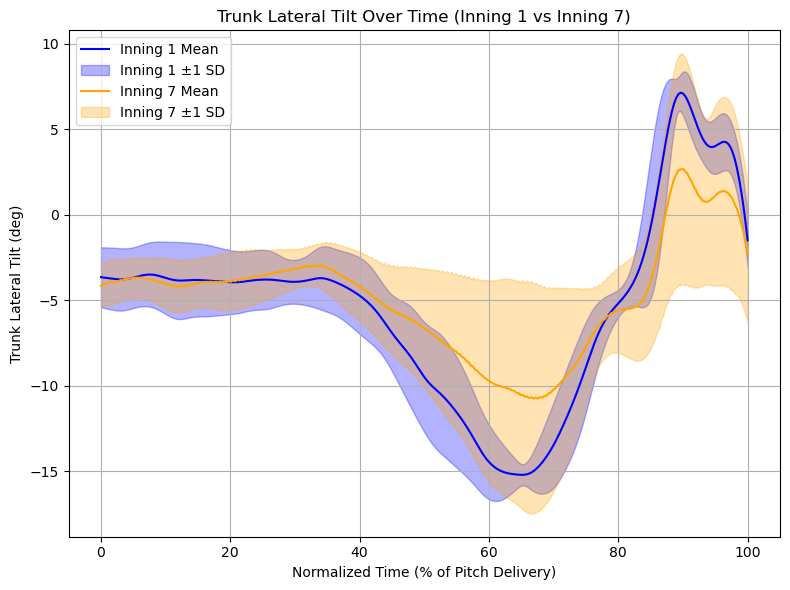

In [303]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Helper Function: Smoothing and Clipping
def smooth_and_clip(signal, clip_value=50):
    """Smooth the signal using Savitzky-Golay filter and clip at a specified value."""
    smoothed_signal = savgol_filter(signal, window_length=11, polyorder=2)
    clipped_signal = np.clip(smoothed_signal, a_min=-clip_value, a_max=clip_value)
    return clipped_signal

# Function to Generate Plot for Trunk Lateral Tilt (No Velocity)
def plot_trunk_lateral_tilt(data, plot_title="Trunk Lateral Tilt Over Time"):
    """Generate mean plots for trunk lateral tilt with SD shading for Inning 1 vs Inning 7."""
    
    # Step 1: Extract and prepare data for analysis
    all_pitch_data_angles = []

    for inning in [1, 7]:
        inning_pitches = data[data['INNING'] == inning]
        
        for pitch_count in inning_pitches['PITCHER_PITCH_COUNT'].unique():
            # Filter out each individual pitch and trim first and last 5 frames
            single_pitch_data = inning_pitches[inning_pitches['PITCHER_PITCH_COUNT'] == pitch_count].iloc[5:-5]

            # Extract necessary columns
            trunk_angle_lateral = single_pitch_data['TRUNK_Y'].values

            # Normalize time to 300 points for uniformity
            normalized_time = np.linspace(0, 100, 300)
            trunk_angle_lateral = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(trunk_angle_lateral)), trunk_angle_lateral)

            # Apply smoothing and clipping
            trunk_angle_lateral_filtered = smooth_and_clip(trunk_angle_lateral, clip_value=50)  # Assume 50 degrees as max tilt

            # Store the results
            all_pitch_data_angles.append((inning, trunk_angle_lateral_filtered, normalized_time))
    
    # Step 2: Aggregate data for mean and standard deviation
    mean_std_dict_angle = {}

    for inning in [1, 7]:
        # Collect data for the given inning
        inning_data_angle = [pitch[1] for pitch in all_pitch_data_angles if pitch[0] == inning]
        inning_data_angle = np.array(inning_data_angle)

        # Compute mean and standard deviation
        mean_values_angle = np.mean(inning_data_angle, axis=0)
        std_values_angle = np.std(inning_data_angle, axis=0)
        
        mean_std_dict_angle[inning] = (mean_values_angle, std_values_angle)
    
    # Step 3: Generate the plot for Trunk Lateral Tilt
    plt.figure(figsize=(8, 6))

    # Extract the normalized time vector
    normalized_time = all_pitch_data_angles[0][2]  # Use time from any pitch since they are standardized
    
    # Plot: Mean Trunk Lateral Tilt with SD shading
    for inning, color in zip([1, 7], ['blue', 'orange']):
        mean_values, std_values = mean_std_dict_angle[inning]
        plt.plot(normalized_time, mean_values, color=color, label=f'Inning {inning} Mean')
        plt.fill_between(normalized_time, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3, label=f'Inning {inning} ±1 SD')

    plt.title(f'{plot_title} (Inning 1 vs Inning 7)')
    plt.xlabel('Normalized Time (% of Pitch Delivery)')
    plt.ylabel('Trunk Lateral Tilt (deg)')
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage with the `signals_df` dataframe
plot_trunk_lateral_tilt(signals_df)


QUESTION 5

In [304]:
import pandas as pd

# Example dataframe: Replace 'metrics_df' with your actual metrics DataFrame variable.
# Assuming `metrics_df` has columns: 'PITCH_TYPE', 'INNING', 'RELEASE_SPEED', 'SPIN_RATE', etc.

# Step 1: Group the data by pitch type
pitch_types = metrics_df['PITCH_TYPE'].unique()

# Step 2: Create a table for each pitch type and display
for pitch in pitch_types:
    # Filter the data for the specific pitch type
    pitch_data = metrics_df[metrics_df['PITCH_TYPE'] == pitch]
    
    # Display the table for each pitch
    display(pitch_data)
    
    # Save each pitch's metrics to a separate Excel file
    output_file_path = f"/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 5/{pitch}_metrics_table.xlsx"
    pitch_data.to_excel(output_file_path, index=False)
    print(f"Metrics table saved for {pitch} at: {output_file_path}")


,INNING,PITCH_TYPE,RELEASE_SPEED,SPIN_RATE
0,7,Curveball,80.3883,3069.98
1,7,Curveball,81.1436,2930.98
2,1,Curveball,82.7500,3023.98
3,7,Curveball,81.7150,2981.98
5,7,Curveball,81.2503,2955.98
8,7,Curveball,80.3561,3059.98
12,1,Curveball,81.3898,2823.98
14,1,Curveball,81.7351,2960.98
16,1,Curveball,82.5758,2987.98
24,1,Curveball,82.6477,2878.98


Metrics table saved for Curveball at: /Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 5/Curveball_metrics_table.xlsx


,INNING,PITCH_TYPE,RELEASE_SPEED,SPIN_RATE
4,1,Fastball,93.7723,2246.98
6,1,Fastball,95.9095,2142.98
7,7,Fastball,92.9483,2328.98
9,1,Fastball,96.1664,2262.98
11,7,Fastball,93.6883,2274.98
15,1,Fastball,96.2683,2247.98
17,1,Fastball,95.4306,2337.98
18,7,Fastball,93.6177,2217.98
19,7,Fastball,93.6038,2295.98
20,1,Fastball,95.3175,2146.98


Metrics table saved for Fastball at: /Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 5/Fastball_metrics_table.xlsx


,INNING,PITCH_TYPE,RELEASE_SPEED,SPIN_RATE
10,7,Changeup,86.4503,1999.98


Metrics table saved for Changeup at: /Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 5/Changeup_metrics_table.xlsx


,INNING,PITCH_TYPE,RELEASE_SPEED,SPIN_RATE
13,7,Sinker,93.1575,2028.98
22,7,Sinker,92.8642,2105.98
26,7,Sinker,93.8723,2202.98


Metrics table saved for Sinker at: /Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Question 5/Sinker_metrics_table.xlsx


In [311]:
import pandas as pd

# Group by each pitch type instead of pitch count
pitch_type_tables = {}
for pitch_type in metrics_data['PITCH_TYPE'].unique():
    pitch_type_tables[pitch_type] = metrics_data[metrics_data['PITCH_TYPE'] == pitch_type]

# Display each table for the pitch types
for pitch_type, table in pitch_type_tables.items():
    print(f"Metrics Table for Pitch Type: {pitch_type}")
    display(table)



Metrics Table for Pitch Type: Curveball


,INNING,PITCHER_PITCH_COUNT,PITCHER_NAME_LAST_FIRST,PITCH_TYPE,RELEASE_SPEED,SPIN_RATE,PITCH_RELEASE_COORDINATES_X,PITCH_RELEASE_COORDINATES_Z,EXTENSION,HORIZONTAL_BREAK,...,SHOULDER_FP_X,SHOULDER_FP_Y,SHOULDER_FP_Z,STRIDELENGTH100,TRUNK_BR_X,TRUNK_BR_Y,TRUNK_BR_Z,TRUNK_FP_X,TRUNK_FP_Y,TRUNK_FP_Z
0,7,94,Player A,Curveball,80.3883,3069.98,-2.649489,5.250047,6.033803,17.356354,...,-28.247541,-82.033676,-51.595837,82.218582,-26.647268,3.785455,111.772652,-23.035557,-3.380013,-1.553947
1,7,91,Player A,Curveball,81.1436,2930.98,-2.596839,5.287482,6.284959,8.552296,...,-28.197557,-82.601646,-45.596077,83.303299,-24.946074,2.657078,112.718834,-23.366488,-5.327053,-3.388054
2,1,9,Player A,Curveball,82.7500,3023.98,-2.437611,5.331092,5.645580,15.747335,...,-28.612041,-80.389153,-53.194824,81.563690,-26.631132,2.990835,110.993118,-24.577394,-4.615892,-4.551186
3,7,106,Player A,Curveball,81.7150,2981.98,-2.556336,5.190663,6.274520,15.719063,...,-29.055071,-80.828445,-50.259247,82.888641,-25.866522,1.413054,111.582634,-23.112663,-4.216677,0.614861
5,7,100,Player A,Curveball,81.2503,2955.98,-2.374216,5.177150,6.398148,13.707928,...,-27.062578,-83.473465,-43.000168,83.433014,-25.090721,1.920672,112.554970,-25.424528,-4.265095,-4.472130
8,7,93,Player A,Curveball,80.3561,3059.98,-2.456977,5.122039,6.272822,13.484267,...,-32.709900,-80.471672,-50.917973,82.248894,-24.755650,0.761694,110.959503,-22.601391,-3.872203,-1.405319
12,1,2,Player A,Curveball,81.3898,2823.98,-2.556472,5.256763,6.268761,10.780823,...,-29.720697,-81.275810,-49.482895,82.607574,-27.124924,1.892839,111.810509,-23.306147,-4.959589,-2.835892
14,1,10,Player A,Curveball,81.7351,2960.98,-2.631316,5.285266,6.326003,13.821207,...,-28.761623,-79.764748,-54.918076,81.924088,-26.894518,3.476691,112.274559,-24.951843,-3.719466,-3.006073
16,1,8,Player A,Curveball,82.5758,2987.98,-2.472142,5.341609,6.277354,11.804528,...,-29.579945,-82.407166,-56.328293,82.829575,-26.206095,3.901311,111.257362,-21.900700,-4.726838,-2.322914
24,1,3,Player A,Curveball,82.6477,2878.98,-2.461848,5.280086,6.325964,9.468936,...,-32.550365,-80.627220,-50.682461,81.638496,-25.676569,1.500708,114.249084,-24.716597,-4.396517,-3.707123


Metrics Table for Pitch Type: Fastball


,INNING,PITCHER_PITCH_COUNT,PITCHER_NAME_LAST_FIRST,PITCH_TYPE,RELEASE_SPEED,SPIN_RATE,PITCH_RELEASE_COORDINATES_X,PITCH_RELEASE_COORDINATES_Z,EXTENSION,HORIZONTAL_BREAK,...,SHOULDER_FP_X,SHOULDER_FP_Y,SHOULDER_FP_Z,STRIDELENGTH100,TRUNK_BR_X,TRUNK_BR_Y,TRUNK_BR_Z,TRUNK_FP_X,TRUNK_FP_Y,TRUNK_FP_Z
4,1,1,Player A,Fastball,93.7723,2246.98,-2.497085,5.418919,6.271444,-16.894970,...,-25.778023,-82.060402,-49.121586,83.345558,-25.800154,3.785414,111.526321,-24.769983,-5.318536,-4.635437
6,1,11,Player A,Fastball,95.9095,2142.98,-2.419988,5.422237,6.297057,-13.377132,...,-36.808903,-78.951263,-53.562141,82.845772,-29.183306,6.071273,110.083153,-20.710176,-5.182637,3.683136
7,7,104,Player A,Fastball,92.9483,2328.98,-2.363028,5.257425,6.141565,-12.260019,...,-29.422485,-77.593803,-47.196499,83.340988,-23.968655,4.494600,111.030563,-24.205931,-3.848805,-1.927063
9,1,7,Player A,Fastball,96.1664,2262.98,-2.389012,5.451761,6.370330,-11.161961,...,-33.232075,-80.250046,-48.204937,82.688751,-27.255713,6.073098,110.708015,-22.571573,-5.750930,-1.402374
11,7,99,Player A,Fastball,93.6883,2274.98,-2.229963,5.228096,6.268786,-15.233662,...,-26.477776,-82.440865,-45.099495,85.017456,-22.010754,6.640155,113.217575,-23.433800,-4.514224,-4.939972
15,1,6,Player A,Fastball,96.2683,2247.98,-2.348280,5.348217,6.191290,-12.458614,...,-29.941633,-78.417915,-47.239101,82.720764,-26.954351,5.186700,111.005821,-24.353785,-5.032383,-4.005783
17,1,5,Player A,Fastball,95.4306,2337.98,-2.604182,5.306679,6.134125,-16.809665,...,-31.891628,-80.141266,-52.005318,83.854156,-27.063686,3.289951,110.473389,-24.005430,-4.798685,-2.912125
18,7,102,Player A,Fastball,93.6177,2217.98,-2.313532,5.261808,6.126977,-13.214187,...,-30.565014,-79.862312,-46.524757,83.721222,-23.489153,5.102801,111.756981,-24.113276,-4.708770,-3.914963
19,7,95,Player A,Fastball,93.6038,2295.98,-2.468554,5.258463,6.161298,-13.945044,...,-31.662947,-82.252235,-47.583775,83.503792,-22.615917,4.556034,113.411827,-23.653606,-4.098802,-1.424110
20,1,13,Player A,Fastball,95.3175,2146.98,-2.399412,5.273663,6.414472,-13.741725,...,-30.263052,-82.214828,-43.022556,83.698044,-26.709871,4.810287,109.905991,-25.659370,-5.196981,-4.502769


Metrics Table for Pitch Type: Changeup


,INNING,PITCHER_PITCH_COUNT,PITCHER_NAME_LAST_FIRST,PITCH_TYPE,RELEASE_SPEED,SPIN_RATE,PITCH_RELEASE_COORDINATES_X,PITCH_RELEASE_COORDINATES_Z,EXTENSION,HORIZONTAL_BREAK,...,SHOULDER_FP_X,SHOULDER_FP_Y,SHOULDER_FP_Z,STRIDELENGTH100,TRUNK_BR_X,TRUNK_BR_Y,TRUNK_BR_Z,TRUNK_FP_X,TRUNK_FP_Y,TRUNK_FP_Z
10,7,97,Player A,Changeup,86.4503,1999.98,-2.597479,5.153388,6.168653,-17.002515,...,-28.660212,-80.941673,-43.454914,82.740089,-23.710735,3.072213,112.486382,-24.396521,-4.215664,-5.062538


Metrics Table for Pitch Type: Sinker


,INNING,PITCHER_PITCH_COUNT,PITCHER_NAME_LAST_FIRST,PITCH_TYPE,RELEASE_SPEED,SPIN_RATE,PITCH_RELEASE_COORDINATES_X,PITCH_RELEASE_COORDINATES_Z,EXTENSION,HORIZONTAL_BREAK,...,SHOULDER_FP_X,SHOULDER_FP_Y,SHOULDER_FP_Z,STRIDELENGTH100,TRUNK_BR_X,TRUNK_BR_Y,TRUNK_BR_Z,TRUNK_FP_X,TRUNK_FP_Y,TRUNK_FP_Z
13,7,105,Player A,Sinker,93.1575,2028.98,-2.323644,5.218787,6.226584,-20.256510,...,-30.659142,-80.881752,-47.621040,83.687706,-23.036591,3.698471,111.840385,-25.648191,-4.601056,-0.840759
22,7,92,Player A,Sinker,92.8642,2105.98,-2.385883,5.297558,6.000820,-17.664659,...,-27.885262,-79.418045,-49.609097,82.882843,-24.817369,4.488160,110.792381,-22.620710,-3.997540,-1.314957
26,7,103,Player A,Sinker,93.8723,2202.98,-2.434863,5.178094,6.172543,-19.130690,...,-31.251926,-76.490402,-56.138737,84.606483,-22.873930,2.826276,112.357765,-22.731970,-4.597240,3.789421


NameError: name 'LinearRegression' is not defined

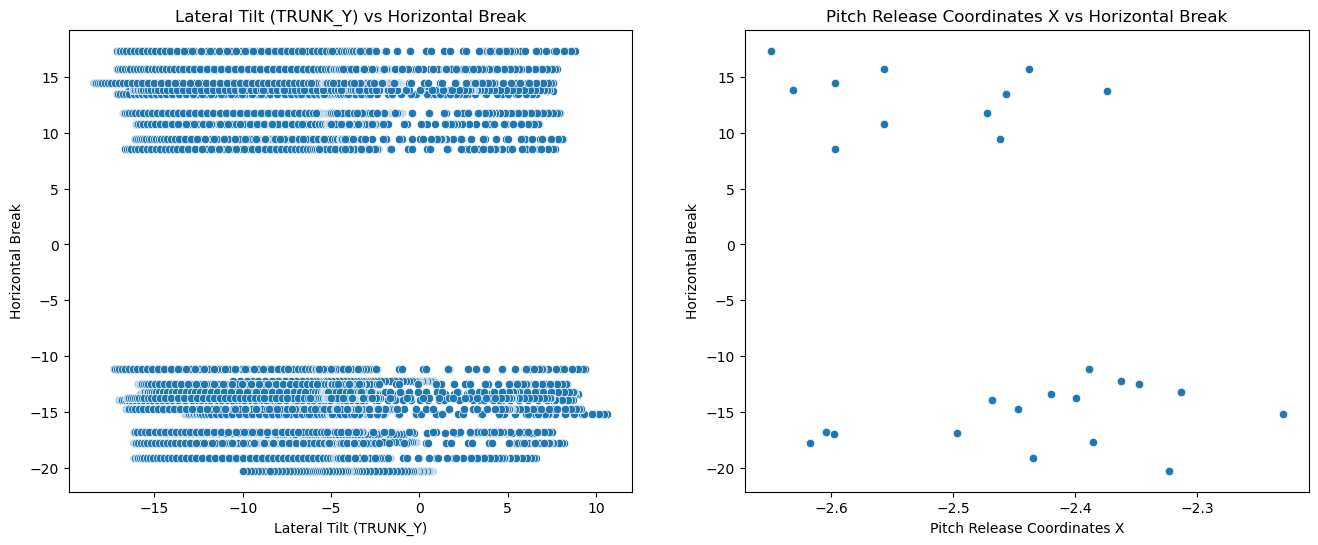

In [316]:
# Convert 'PITCHER_PITCH_COUNT' to int in both DataFrames
metrics_data['PITCHER_PITCH_COUNT'] = metrics_data['PITCHER_PITCH_COUNT'].astype(int)
signals_df['PITCHER_PITCH_COUNT'] = signals_df['PITCHER_PITCH_COUNT'].astype(int)

# Now perform the merge
merged_df = pd.merge(metrics_data, signals_df, on='PITCHER_PITCH_COUNT', how='inner')

# Variables for plotting
x1 = merged_df['TRUNK_Y']  # This corresponds to lateral tilt
x2 = merged_df['PITCH_RELEASE_COORDINATES_X']
y = merged_df['HORIZONTAL_BREAK']

# Prepare scatter plots for both variables against horizontal break
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot for Lateral Tilt (TRUNK_Y) vs Horizontal Break
sns.scatterplot(x=x1, y=y, ax=ax1)
ax1.set_title("Lateral Tilt (TRUNK_Y) vs Horizontal Break")
ax1.set_xlabel("Lateral Tilt (TRUNK_Y)")
ax1.set_ylabel("Horizontal Break")

# Scatter plot for Pitch Release Coordinates X vs Horizontal Break
sns.scatterplot(x=x2, y=y, ax=ax2)
ax2.set_title("Pitch Release Coordinates X vs Horizontal Break")
ax2.set_xlabel("Pitch Release Coordinates X")
ax2.set_ylabel("Horizontal Break")

# Perform and plot linear regression
x1 = x1.values.reshape(-1, 1)  # Reshape for sklearn
x2 = x2.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

# Linear regression models
regressor1 = LinearRegression().fit(x1, y)
regressor2 = LinearRegression().fit(x2, y)

# Predict values
y_pred1 = regressor1.predict(x1)
y_pred2 = regressor2.predict(x2)

# Plot regression line on scatter plots
ax1.plot(x1, y_pred1, color='red', linewidth=2)
ax2.plot(x2, y_pred2, color='red', linewidth=2)

# Show plots
plt.tight_layout()
plt.show()

# Return coefficients of regression
regressor1.coef_, regressor2.coef_


In [321]:
import pandas as pd

# Sample data similar to what you have shared
data = {
    'INNING': [1, 1, 7, 7, 7, 7],
    'PITCH_TYPE': ['Curveball', 'Fastball', 'Changeup', 'Curveball', 'Fastball', 'Sinker'],
    'Mean_Pitch_Velocity': [82.3, 95.5, 86.5, 81.0, 93.6, 93.3],
    'Std_Pitch_Velocity': [0.6, 0.9, 0.0, 0.6, 0.5, 0.5],
    'Mean_Spin_Rate': [2955.6, 2234.0, 2000.0, 2999.8, 2278.2, 2112.6],
    'Std_Spin_Rate': [88.80, 68.55, 0.00, 62.29, 40.49, 87.19],
    'Peak_Shoulder_Internal_Rotation_Velocity_Mean': [4917.43, 4740.54, None, 4792.03, 4298.60, 4654.83],
    'Peak_Shoulder_Internal_Rotation_Velocity_Std': [429.11, 226.96, None, 351.50, 45.77, 0.00],
    'Peak_Elbow_Extension_Velocity_Mean': [2473.28, 2359.37, None, 2411.74, 2489.53, 2520.61],
    'Peak_Elbow_Extension_Velocity_Std': [182.30, 104.27, None, 103.40, 83.83, 0.00],
    'Peak_Pelvis_Rotational_Velocity_Mean': [770.07, 782.23, None, 800.65, 797.16, 819.88],
    'Peak_Pelvis_Rotational_Velocity_Std': [24.77, 15.73, None, 14.42, 19.23, 0.00],
    'Peak_Trunk_Rotational_Velocity_Mean': [1118.79, 1144.13, None, 1111.42, 1120.39, 1143.35],
    'Peak_Trunk_Rotational_Velocity_Std': [12.12, 17.76, None, 16.11, 21.75, 0.00],
    'Max_External_Rotation_Mean': [177.01, 178.67, None, 173.99, 171.12, 178.96],
    'Max_External_Rotation_Std': [3.80, 1.82, None, 2.59, 2.39, 0.00],
    'Max_Elbow_Varus_Torque_Mean': [118.88, 126.21, None, 113.94, 135.18, 133.92],
    'Max_Elbow_Varus_Torque_Std': [10.06, 9.16, None, 15.80, 3.28, 0.00]
}

# Create the initial DataFrame
df = pd.DataFrame(data)

# Function to combine mean and standard deviation into 'Mean ± Std' format
def combine_columns(mean_col, std_col):
    return df[mean_col].astype(str) + " ± " + df[std_col].astype(str)

# List of column pairs to combine
columns_to_combine = [
    ('Mean_Pitch_Velocity', 'Std_Pitch_Velocity'),
    ('Mean_Spin_Rate', 'Std_Spin_Rate'),
    ('Peak_Shoulder_Internal_Rotation_Velocity_Mean', 'Peak_Shoulder_Internal_Rotation_Velocity_Std'),
    ('Peak_Elbow_Extension_Velocity_Mean', 'Peak_Elbow_Extension_Velocity_Std'),
    ('Peak_Pelvis_Rotational_Velocity_Mean', 'Peak_Pelvis_Rotational_Velocity_Std'),
    ('Peak_Trunk_Rotational_Velocity_Mean', 'Peak_Trunk_Rotational_Velocity_Std'),
    ('Max_External_Rotation_Mean', 'Max_External_Rotation_Std'),
    ('Max_Elbow_Varus_Torque_Mean', 'Max_Elbow_Varus_Torque_Std')
]

# Apply the combination and create new columns
for mean_col, std_col in columns_to_combine:
    new_col_name = mean_col.split('_Mean')[0]  # Get the base name without '_Mean'
    df[new_col_name] = combine_columns(mean_col, std_col)

# Create a new DataFrame with only the combined columns and identifiers
df_combined = df[['INNING', 'PITCH_TYPE'] + [col.split('_Mean')[0] for col, _ in columns_to_combine]]


display(df_combined)



,INNING,PITCH_TYPE,Mean_Pitch_Velocity,Mean_Spin_Rate,Peak_Shoulder_Internal_Rotation_Velocity,Peak_Elbow_Extension_Velocity,Peak_Pelvis_Rotational_Velocity,Peak_Trunk_Rotational_Velocity,Max_External_Rotation,Max_Elbow_Varus_Torque
0,1,Curveball,82.3 ± 0.6,2955.6 ± 88.8,4917.43 ± 429.11,2473.28 ± 182.3,770.07 ± 24.77,1118.79 ± 12.12,177.01 ± 3.8,118.88 ± 10.06
1,1,Fastball,95.5 ± 0.9,2234.0 ± 68.55,4740.54 ± 226.96,2359.37 ± 104.27,782.23 ± 15.73,1144.13 ± 17.76,178.67 ± 1.82,126.21 ± 9.16
2,7,Changeup,86.5 ± 0.0,2000.0 ± 0.0,nan ± nan,nan ± nan,nan ± nan,nan ± nan,nan ± nan,nan ± nan
3,7,Curveball,81.0 ± 0.6,2999.8 ± 62.29,4792.03 ± 351.5,2411.74 ± 103.4,800.65 ± 14.42,1111.42 ± 16.11,173.99 ± 2.59,113.94 ± 15.8
4,7,Fastball,93.6 ± 0.5,2278.2 ± 40.49,4298.6 ± 45.77,2489.53 ± 83.83,797.16 ± 19.23,1120.39 ± 21.75,171.12 ± 2.39,135.18 ± 3.28
5,7,Sinker,93.3 ± 0.5,2112.6 ± 87.19,4654.83 ± 0.0,2520.61 ± 0.0,819.88 ± 0.0,1143.35 ± 0.0,178.96 ± 0.0,133.92 ± 0.0
